In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(491695, 832)
(491695, 8)
validation
(85893, 832)
(85893, 8)
test
(41645, 832)
(41645, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1543048 (5.89 MB)


Trainable params: 1543048 (5.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/50 [..............................] - ETA: 1:24 - loss: 2.1680 - STD: 0.0470 - MAE: 0.2208

 4/50 [=>............................] - ETA: 1s - loss: 1.6607 - STD: 0.1155 - MAE: 0.1817  

 7/50 [===>..........................] - ETA: 6s - loss: 1.5830 - STD: 0.1688 - MAE: 0.1603

10/50 [=====>........................] - ETA: 4s - loss: 1.5215 - STD: 0.1841 - MAE: 0.1535

13/50 [======>.......................] - ETA: 3s - loss: 1.4935 - STD: 0.1832 - MAE: 0.1535

16/50 [========>.....................] - ETA: 2s - loss: 1.4754 - STD: 0.1809 - MAE: 0.1541

18/50 [=========>....................] - ETA: 2s - loss: 1.4641 - STD: 0.1811 - MAE: 0.1539

21/50 [===========>..................] - ETA: 1s - loss: 1.4519 - STD: 0.1830 - MAE: 0.1530

24/50 [=============>................] - ETA: 1s - loss: 1.4408 - STD: 0.1850 - MAE: 0.1520

27/50 [===============>..............] - ETA: 1s - loss: 1.4332 - STD: 0.1854 - MAE: 0.1517

30/50 [=================>............] - ETA: 0s - loss: 1.4268 - STD: 0.1846 - MAE: 0.1519

33/50 [==================>...........] - ETA: 0s - loss: 1.4219 - STD: 0.1835 - MAE: 0.1522

36/50 [====================>.........] - ETA: 0s - loss: 1.4161 - STD: 0.1831 - MAE: 0.1522

39/50 [======================>.......] - ETA: 0s - loss: 1.4124 - STD: 0.1834 - MAE: 0.1520

42/50 [========================>.....] - ETA: 0s - loss: 1.4090 - STD: 0.1840 - MAE: 0.1518

45/50 [==========================>...] - ETA: 0s - loss: 1.4052 - STD: 0.1842 - MAE: 0.1516

48/50 [===========================>..] - ETA: 0s - loss: 1.4024 - STD: 0.1842 - MAE: 0.1516

50/50 [==============================] - 4s 56ms/step - loss: 1.4005 - STD: 0.1841 - MAE: 0.1516 - val_loss: 1.3281 - val_STD: 0.1834 - val_MAE: 0.1491


Epoch 2/10000


 1/50 [..............................] - ETA: 2s - loss: 1.3619 - STD: 0.1834 - MAE: 0.1510

 3/50 [>.............................] - ETA: 1s - loss: 1.3638 - STD: 0.1843 - MAE: 0.1510

 6/50 [==>...........................] - ETA: 1s - loss: 1.3622 - STD: 0.1849 - MAE: 0.1505

 9/50 [====>.........................] - ETA: 1s - loss: 1.3646 - STD: 0.1850 - MAE: 0.1507

12/50 [======>.......................] - ETA: 0s - loss: 1.3616 - STD: 0.1844 - MAE: 0.1508

15/50 [========>.....................] - ETA: 0s - loss: 1.3624 - STD: 0.1840 - MAE: 0.1509

18/50 [=========>....................] - ETA: 0s - loss: 1.3618 - STD: 0.1840 - MAE: 0.1509

21/50 [===========>..................] - ETA: 0s - loss: 1.3610 - STD: 0.1843 - MAE: 0.1507

24/50 [=============>................] - ETA: 0s - loss: 1.3624 - STD: 0.1845 - MAE: 0.1507

26/50 [==============>...............] - ETA: 0s - loss: 1.3624 - STD: 0.1844 - MAE: 0.1508

29/50 [================>.............] - ETA: 0s - loss: 1.3621 - STD: 0.1842 - MAE: 0.1508

32/50 [==================>...........] - ETA: 0s - loss: 1.3614 - STD: 0.1842 - MAE: 0.1508

35/50 [====================>.........] - ETA: 0s - loss: 1.3615 - STD: 0.1843 - MAE: 0.1507

38/50 [=====================>........] - ETA: 0s - loss: 1.3610 - STD: 0.1842 - MAE: 0.1507

41/50 [=======================>......] - ETA: 0s - loss: 1.3597 - STD: 0.1840 - MAE: 0.1507

44/50 [=========================>....] - ETA: 0s - loss: 1.3593 - STD: 0.1841 - MAE: 0.1507

47/50 [===========================>..] - ETA: 0s - loss: 1.3581 - STD: 0.1840 - MAE: 0.1506

50/50 [==============================] - ETA: 0s - loss: 1.3563 - STD: 0.1841 - MAE: 0.1505

50/50 [==============================] - 1s 28ms/step - loss: 1.3563 - STD: 0.1841 - MAE: 0.1505 - val_loss: 1.2944 - val_STD: 0.1844 - val_MAE: 0.1466


Epoch 3/10000


 1/50 [..............................] - ETA: 2s - loss: 1.3260 - STD: 0.1866 - MAE: 0.1478

 4/50 [=>............................] - ETA: 1s - loss: 1.3263 - STD: 0.1849 - MAE: 0.1483

 7/50 [===>..........................] - ETA: 1s - loss: 1.3251 - STD: 0.1847 - MAE: 0.1483

10/50 [=====>........................] - ETA: 0s - loss: 1.3197 - STD: 0.1848 - MAE: 0.1479

13/50 [======>.......................] - ETA: 0s - loss: 1.3144 - STD: 0.1861 - MAE: 0.1471

16/50 [========>.....................] - ETA: 0s - loss: 1.3114 - STD: 0.1868 - MAE: 0.1466

19/50 [==========>...................] - ETA: 0s - loss: 1.3067 - STD: 0.1877 - MAE: 0.1460

22/50 [============>.................] - ETA: 0s - loss: 1.3025 - STD: 0.1884 - MAE: 0.1455

25/50 [==============>...............] - ETA: 0s - loss: 1.3003 - STD: 0.1889 - MAE: 0.1452

28/50 [===============>..............] - ETA: 0s - loss: 1.2972 - STD: 0.1897 - MAE: 0.1447

31/50 [=================>............] - ETA: 0s - loss: 1.2954 - STD: 0.1902 - MAE: 0.1444

34/50 [===================>..........] - ETA: 0s - loss: 1.2933 - STD: 0.1906 - MAE: 0.1441

37/50 [=====================>........] - ETA: 0s - loss: 1.2908 - STD: 0.1911 - MAE: 0.1438

40/50 [=======================>......] - ETA: 0s - loss: 1.2878 - STD: 0.1913 - MAE: 0.1436

43/50 [========================>.....] - ETA: 0s - loss: 1.2851 - STD: 0.1917 - MAE: 0.1433

46/50 [==========================>...] - ETA: 0s - loss: 1.2827 - STD: 0.1924 - MAE: 0.1429

49/50 [============================>.] - ETA: 0s - loss: 1.2807 - STD: 0.1925 - MAE: 0.1428

50/50 [==============================] - 1s 27ms/step - loss: 1.2796 - STD: 0.1928 - MAE: 0.1426 - val_loss: 1.2142 - val_STD: 0.1859 - val_MAE: 0.1404


Epoch 4/10000


 1/50 [..............................] - ETA: 2s - loss: 1.2368 - STD: 0.1967 - MAE: 0.1392

 3/50 [>.............................] - ETA: 1s - loss: 1.2440 - STD: 0.1957 - MAE: 0.1397

 6/50 [==>...........................] - ETA: 1s - loss: 1.2362 - STD: 0.1987 - MAE: 0.1381

 9/50 [====>.........................] - ETA: 1s - loss: 1.2290 - STD: 0.2001 - MAE: 0.1372

12/50 [======>.......................] - ETA: 0s - loss: 1.2249 - STD: 0.2007 - MAE: 0.1367

15/50 [========>.....................] - ETA: 0s - loss: 1.2220 - STD: 0.2010 - MAE: 0.1362

18/50 [=========>....................] - ETA: 0s - loss: 1.2185 - STD: 0.2014 - MAE: 0.1359

21/50 [===========>..................] - ETA: 0s - loss: 1.2179 - STD: 0.2017 - MAE: 0.1357

23/50 [============>.................] - ETA: 0s - loss: 1.2151 - STD: 0.2013 - MAE: 0.1358

26/50 [==============>...............] - ETA: 0s - loss: 1.2132 - STD: 0.2018 - MAE: 0.1355

29/50 [================>.............] - ETA: 0s - loss: 1.2091 - STD: 0.2022 - MAE: 0.1352

32/50 [==================>...........] - ETA: 0s - loss: 1.2055 - STD: 0.2021 - MAE: 0.1352

34/50 [===================>..........] - ETA: 0s - loss: 1.2024 - STD: 0.2026 - MAE: 0.1349

37/50 [=====================>........] - ETA: 0s - loss: 1.1985 - STD: 0.2029 - MAE: 0.1346

40/50 [=======================>......] - ETA: 0s - loss: 1.1939 - STD: 0.2031 - MAE: 0.1344

43/50 [========================>.....] - ETA: 0s - loss: 1.1900 - STD: 0.2034 - MAE: 0.1341

46/50 [==========================>...] - ETA: 0s - loss: 1.1866 - STD: 0.2036 - MAE: 0.1339

49/50 [============================>.] - ETA: 0s - loss: 1.1826 - STD: 0.2041 - MAE: 0.1336

50/50 [==============================] - 1s 28ms/step - loss: 1.1810 - STD: 0.2041 - MAE: 0.1335 - val_loss: 1.0850 - val_STD: 0.2121 - val_MAE: 0.1252


Epoch 5/10000


 1/50 [..............................] - ETA: 2s - loss: 1.1096 - STD: 0.2202 - MAE: 0.1246

 4/50 [=>............................] - ETA: 1s - loss: 1.1196 - STD: 0.2119 - MAE: 0.1283

 7/50 [===>..........................] - ETA: 1s - loss: 1.1131 - STD: 0.2117 - MAE: 0.1281

10/50 [=====>........................] - ETA: 0s - loss: 1.1146 - STD: 0.2120 - MAE: 0.1281

13/50 [======>.......................] - ETA: 0s - loss: 1.1139 - STD: 0.2124 - MAE: 0.1278

16/50 [========>.....................] - ETA: 0s - loss: 1.1126 - STD: 0.2122 - MAE: 0.1280

19/50 [==========>...................] - ETA: 0s - loss: 1.1124 - STD: 0.2117 - MAE: 0.1281

22/50 [============>.................] - ETA: 0s - loss: 1.1128 - STD: 0.2112 - MAE: 0.1283

25/50 [==============>...............] - ETA: 0s - loss: 1.1117 - STD: 0.2118 - MAE: 0.1281

28/50 [===============>..............] - ETA: 0s - loss: 1.1108 - STD: 0.2120 - MAE: 0.1280

31/50 [=================>............] - ETA: 0s - loss: 1.1099 - STD: 0.2115 - MAE: 0.1282

34/50 [===================>..........] - ETA: 0s - loss: 1.1085 - STD: 0.2117 - MAE: 0.1281

37/50 [=====================>........] - ETA: 0s - loss: 1.1074 - STD: 0.2118 - MAE: 0.1280

39/50 [======================>.......] - ETA: 0s - loss: 1.1063 - STD: 0.2117 - MAE: 0.1280

42/50 [========================>.....] - ETA: 0s - loss: 1.1045 - STD: 0.2119 - MAE: 0.1279

45/50 [==========================>...] - ETA: 0s - loss: 1.1025 - STD: 0.2121 - MAE: 0.1277

48/50 [===========================>..] - ETA: 0s - loss: 1.1013 - STD: 0.2121 - MAE: 0.1276

50/50 [==============================] - 1s 28ms/step - loss: 1.1004 - STD: 0.2121 - MAE: 0.1277 - val_loss: 1.0424 - val_STD: 0.2091 - val_MAE: 0.1249


Epoch 6/10000


 1/50 [..............................] - ETA: 2s - loss: 1.0441 - STD: 0.2182 - MAE: 0.1226

 4/50 [=>............................] - ETA: 1s - loss: 1.0660 - STD: 0.2148 - MAE: 0.1252

 7/50 [===>..........................] - ETA: 1s - loss: 1.0724 - STD: 0.2148 - MAE: 0.1256

10/50 [=====>........................] - ETA: 0s - loss: 1.0725 - STD: 0.2147 - MAE: 0.1257

13/50 [======>.......................] - ETA: 0s - loss: 1.0701 - STD: 0.2138 - MAE: 0.1259

16/50 [========>.....................] - ETA: 0s - loss: 1.0685 - STD: 0.2138 - MAE: 0.1259

19/50 [==========>...................] - ETA: 0s - loss: 1.0652 - STD: 0.2145 - MAE: 0.1255

22/50 [============>.................] - ETA: 0s - loss: 1.0642 - STD: 0.2147 - MAE: 0.1254

25/50 [==============>...............] - ETA: 0s - loss: 1.0625 - STD: 0.2141 - MAE: 0.1256

28/50 [===============>..............] - ETA: 0s - loss: 1.0607 - STD: 0.2144 - MAE: 0.1254

30/50 [=================>............] - ETA: 0s - loss: 1.0595 - STD: 0.2145 - MAE: 0.1253

33/50 [==================>...........] - ETA: 0s - loss: 1.0580 - STD: 0.2144 - MAE: 0.1252

36/50 [====================>.........] - ETA: 0s - loss: 1.0570 - STD: 0.2146 - MAE: 0.1252

39/50 [======================>.......] - ETA: 0s - loss: 1.0553 - STD: 0.2149 - MAE: 0.1250

42/50 [========================>.....] - ETA: 0s - loss: 1.0541 - STD: 0.2149 - MAE: 0.1249

45/50 [==========================>...] - ETA: 0s - loss: 1.0530 - STD: 0.2148 - MAE: 0.1249

47/50 [===========================>..] - ETA: 0s - loss: 1.0516 - STD: 0.2150 - MAE: 0.1248

50/50 [==============================] - ETA: 0s - loss: 1.0502 - STD: 0.2150 - MAE: 0.1247

50/50 [==============================] - 1s 28ms/step - loss: 1.0502 - STD: 0.2150 - MAE: 0.1247 - val_loss: 1.0004 - val_STD: 0.2114 - val_MAE: 0.1229


Epoch 7/10000


 1/50 [..............................] - ETA: 2s - loss: 1.0081 - STD: 0.2201 - MAE: 0.1212

 4/50 [=>............................] - ETA: 1s - loss: 1.0022 - STD: 0.2189 - MAE: 0.1213

 7/50 [===>..........................] - ETA: 1s - loss: 1.0014 - STD: 0.2181 - MAE: 0.1215

10/50 [=====>........................] - ETA: 0s - loss: 1.0021 - STD: 0.2185 - MAE: 0.1213

13/50 [======>.......................] - ETA: 0s - loss: 1.0011 - STD: 0.2189 - MAE: 0.1211

16/50 [========>.....................] - ETA: 0s - loss: 0.9999 - STD: 0.2193 - MAE: 0.1209

19/50 [==========>...................] - ETA: 0s - loss: 0.9970 - STD: 0.2196 - MAE: 0.1206

21/50 [===========>..................] - ETA: 0s - loss: 0.9967 - STD: 0.2193 - MAE: 0.1208

24/50 [=============>................] - ETA: 0s - loss: 0.9955 - STD: 0.2197 - MAE: 0.1207

27/50 [===============>..............] - ETA: 0s - loss: 0.9943 - STD: 0.2197 - MAE: 0.1207

30/50 [=================>............] - ETA: 0s - loss: 0.9926 - STD: 0.2195 - MAE: 0.1207

33/50 [==================>...........] - ETA: 0s - loss: 0.9897 - STD: 0.2198 - MAE: 0.1205

36/50 [====================>.........] - ETA: 0s - loss: 0.9873 - STD: 0.2201 - MAE: 0.1203

39/50 [======================>.......] - ETA: 0s - loss: 0.9849 - STD: 0.2203 - MAE: 0.1201

42/50 [========================>.....] - ETA: 0s - loss: 0.9820 - STD: 0.2205 - MAE: 0.1199

45/50 [==========================>...] - ETA: 0s - loss: 0.9806 - STD: 0.2205 - MAE: 0.1199

48/50 [===========================>..] - ETA: 0s - loss: 0.9789 - STD: 0.2205 - MAE: 0.1199

50/50 [==============================] - 1s 27ms/step - loss: 0.9778 - STD: 0.2208 - MAE: 0.1198 - val_loss: 0.9389 - val_STD: 0.2095 - val_MAE: 0.1224


Epoch 8/10000


 1/50 [..............................] - ETA: 2s - loss: 0.9367 - STD: 0.2185 - MAE: 0.1195

 4/50 [=>............................] - ETA: 1s - loss: 0.9394 - STD: 0.2239 - MAE: 0.1171

 7/50 [===>..........................] - ETA: 1s - loss: 0.9376 - STD: 0.2237 - MAE: 0.1171

10/50 [=====>........................] - ETA: 0s - loss: 0.9410 - STD: 0.2235 - MAE: 0.1175

13/50 [======>.......................] - ETA: 0s - loss: 0.9400 - STD: 0.2231 - MAE: 0.1176

16/50 [========>.....................] - ETA: 0s - loss: 0.9404 - STD: 0.2231 - MAE: 0.1176

19/50 [==========>...................] - ETA: 0s - loss: 0.9387 - STD: 0.2237 - MAE: 0.1173

21/50 [===========>..................] - ETA: 0s - loss: 0.9388 - STD: 0.2238 - MAE: 0.1172

24/50 [=============>................] - ETA: 0s - loss: 0.9382 - STD: 0.2238 - MAE: 0.1172

27/50 [===============>..............] - ETA: 0s - loss: 0.9386 - STD: 0.2241 - MAE: 0.1172

30/50 [=================>............] - ETA: 0s - loss: 0.9383 - STD: 0.2241 - MAE: 0.1171

33/50 [==================>...........] - ETA: 0s - loss: 0.9365 - STD: 0.2240 - MAE: 0.1171

36/50 [====================>.........] - ETA: 0s - loss: 0.9357 - STD: 0.2241 - MAE: 0.1170

39/50 [======================>.......] - ETA: 0s - loss: 0.9344 - STD: 0.2244 - MAE: 0.1168

41/50 [=======================>......] - ETA: 0s - loss: 0.9337 - STD: 0.2246 - MAE: 0.1167

44/50 [=========================>....] - ETA: 0s - loss: 0.9317 - STD: 0.2246 - MAE: 0.1166

47/50 [===========================>..] - ETA: 0s - loss: 0.9304 - STD: 0.2246 - MAE: 0.1166

50/50 [==============================] - ETA: 0s - loss: 0.9293 - STD: 0.2249 - MAE: 0.1164

50/50 [==============================] - 1s 28ms/step - loss: 0.9293 - STD: 0.2249 - MAE: 0.1164 - val_loss: 0.9129 - val_STD: 0.2168 - val_MAE: 0.1185


Epoch 9/10000


 1/50 [..............................] - ETA: 2s - loss: 0.9106 - STD: 0.2239 - MAE: 0.1162

 4/50 [=>............................] - ETA: 1s - loss: 0.9071 - STD: 0.2271 - MAE: 0.1145

 7/50 [===>..........................] - ETA: 1s - loss: 0.9109 - STD: 0.2264 - MAE: 0.1150

 9/50 [====>.........................] - ETA: 0s - loss: 0.9098 - STD: 0.2262 - MAE: 0.1150

12/50 [======>.......................] - ETA: 0s - loss: 0.9096 - STD: 0.2265 - MAE: 0.1148

15/50 [========>.....................] - ETA: 0s - loss: 0.9091 - STD: 0.2270 - MAE: 0.1146

18/50 [=========>....................] - ETA: 0s - loss: 0.9100 - STD: 0.2270 - MAE: 0.1147

21/50 [===========>..................] - ETA: 0s - loss: 0.9092 - STD: 0.2268 - MAE: 0.1147

24/50 [=============>................] - ETA: 0s - loss: 0.9097 - STD: 0.2266 - MAE: 0.1149

27/50 [===============>..............] - ETA: 0s - loss: 0.9102 - STD: 0.2265 - MAE: 0.1150

30/50 [=================>............] - ETA: 0s - loss: 0.9091 - STD: 0.2267 - MAE: 0.1148

33/50 [==================>...........] - ETA: 0s - loss: 0.9083 - STD: 0.2268 - MAE: 0.1148

36/50 [====================>.........] - ETA: 0s - loss: 0.9081 - STD: 0.2268 - MAE: 0.1148

39/50 [======================>.......] - ETA: 0s - loss: 0.9086 - STD: 0.2268 - MAE: 0.1148

42/50 [========================>.....] - ETA: 0s - loss: 0.9086 - STD: 0.2269 - MAE: 0.1148

45/50 [==========================>...] - ETA: 0s - loss: 0.9075 - STD: 0.2271 - MAE: 0.1146

47/50 [===========================>..] - ETA: 0s - loss: 0.9071 - STD: 0.2269 - MAE: 0.1147

50/50 [==============================] - ETA: 0s - loss: 0.9057 - STD: 0.2271 - MAE: 0.1146

50/50 [==============================] - 1s 28ms/step - loss: 0.9057 - STD: 0.2271 - MAE: 0.1146 - val_loss: 0.8816 - val_STD: 0.2220 - val_MAE: 0.1149


Epoch 10/10000


 1/50 [..............................] - ETA: 2s - loss: 0.9030 - STD: 0.2284 - MAE: 0.1137

 4/50 [=>............................] - ETA: 1s - loss: 0.8964 - STD: 0.2279 - MAE: 0.1138

 7/50 [===>..........................] - ETA: 1s - loss: 0.8914 - STD: 0.2280 - MAE: 0.1135

10/50 [=====>........................] - ETA: 0s - loss: 0.8905 - STD: 0.2288 - MAE: 0.1131

13/50 [======>.......................] - ETA: 0s - loss: 0.8916 - STD: 0.2287 - MAE: 0.1133

15/50 [========>.....................] - ETA: 0s - loss: 0.8910 - STD: 0.2286 - MAE: 0.1133

18/50 [=========>....................] - ETA: 0s - loss: 0.8899 - STD: 0.2287 - MAE: 0.1132

21/50 [===========>..................] - ETA: 0s - loss: 0.8915 - STD: 0.2286 - MAE: 0.1134

24/50 [=============>................] - ETA: 0s - loss: 0.8902 - STD: 0.2286 - MAE: 0.1133

27/50 [===============>..............] - ETA: 0s - loss: 0.8899 - STD: 0.2286 - MAE: 0.1133

30/50 [=================>............] - ETA: 0s - loss: 0.8907 - STD: 0.2288 - MAE: 0.1132

33/50 [==================>...........] - ETA: 0s - loss: 0.8900 - STD: 0.2288 - MAE: 0.1132

36/50 [====================>.........] - ETA: 0s - loss: 0.8901 - STD: 0.2288 - MAE: 0.1132

39/50 [======================>.......] - ETA: 0s - loss: 0.8897 - STD: 0.2289 - MAE: 0.1131

42/50 [========================>.....] - ETA: 0s - loss: 0.8887 - STD: 0.2290 - MAE: 0.1130

45/50 [==========================>...] - ETA: 0s - loss: 0.8879 - STD: 0.2290 - MAE: 0.1130

48/50 [===========================>..] - ETA: 0s - loss: 0.8874 - STD: 0.2290 - MAE: 0.1129

50/50 [==============================] - 1s 27ms/step - loss: 0.8865 - STD: 0.2291 - MAE: 0.1128 - val_loss: 0.8899 - val_STD: 0.2228 - val_MAE: 0.1148


Epoch 11/10000


 1/50 [..............................] - ETA: 0s - loss: 0.8988 - STD: 0.2293 - MAE: 0.1139

 3/50 [>.............................] - ETA: 1s - loss: 0.8795 - STD: 0.2291 - MAE: 0.1130

 5/50 [==>...........................] - ETA: 1s - loss: 0.8841 - STD: 0.2288 - MAE: 0.1132

 8/50 [===>..........................] - ETA: 1s - loss: 0.8813 - STD: 0.2294 - MAE: 0.1127

11/50 [=====>........................] - ETA: 0s - loss: 0.8811 - STD: 0.2294 - MAE: 0.1126

14/50 [=======>......................] - ETA: 0s - loss: 0.8784 - STD: 0.2298 - MAE: 0.1122

17/50 [=========>....................] - ETA: 0s - loss: 0.8763 - STD: 0.2298 - MAE: 0.1121

20/50 [===========>..................] - ETA: 0s - loss: 0.8761 - STD: 0.2299 - MAE: 0.1120

23/50 [============>.................] - ETA: 0s - loss: 0.8756 - STD: 0.2300 - MAE: 0.1120

26/50 [==============>...............] - ETA: 0s - loss: 0.8740 - STD: 0.2301 - MAE: 0.1119

28/50 [===============>..............] - ETA: 0s - loss: 0.8751 - STD: 0.2301 - MAE: 0.1119

31/50 [=================>............] - ETA: 0s - loss: 0.8748 - STD: 0.2304 - MAE: 0.1118

34/50 [===================>..........] - ETA: 0s - loss: 0.8745 - STD: 0.2305 - MAE: 0.1117

37/50 [=====================>........] - ETA: 0s - loss: 0.8737 - STD: 0.2304 - MAE: 0.1117

40/50 [=======================>......] - ETA: 0s - loss: 0.8734 - STD: 0.2305 - MAE: 0.1116

43/50 [========================>.....] - ETA: 0s - loss: 0.8736 - STD: 0.2306 - MAE: 0.1116

46/50 [==========================>...] - ETA: 0s - loss: 0.8727 - STD: 0.2305 - MAE: 0.1117

49/50 [============================>.] - ETA: 0s - loss: 0.8723 - STD: 0.2306 - MAE: 0.1116

50/50 [==============================] - 1s 28ms/step - loss: 0.8719 - STD: 0.2306 - MAE: 0.1116 - val_loss: 0.8767 - val_STD: 0.2208 - val_MAE: 0.1154


Epoch 12/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8731 - STD: 0.2263 - MAE: 0.1137

 4/50 [=>............................] - ETA: 1s - loss: 0.8689 - STD: 0.2303 - MAE: 0.1117

 7/50 [===>..........................] - ETA: 1s - loss: 0.8635 - STD: 0.2316 - MAE: 0.1109

10/50 [=====>........................] - ETA: 0s - loss: 0.8615 - STD: 0.2315 - MAE: 0.1108

13/50 [======>.......................] - ETA: 0s - loss: 0.8624 - STD: 0.2318 - MAE: 0.1107

16/50 [========>.....................] - ETA: 0s - loss: 0.8589 - STD: 0.2319 - MAE: 0.1104

19/50 [==========>...................] - ETA: 0s - loss: 0.8562 - STD: 0.2318 - MAE: 0.1103

22/50 [============>.................] - ETA: 0s - loss: 0.8563 - STD: 0.2321 - MAE: 0.1102

24/50 [=============>................] - ETA: 0s - loss: 0.8571 - STD: 0.2318 - MAE: 0.1104

27/50 [===============>..............] - ETA: 0s - loss: 0.8566 - STD: 0.2319 - MAE: 0.1103

30/50 [=================>............] - ETA: 0s - loss: 0.8568 - STD: 0.2321 - MAE: 0.1102

33/50 [==================>...........] - ETA: 0s - loss: 0.8576 - STD: 0.2319 - MAE: 0.1104

36/50 [====================>.........] - ETA: 0s - loss: 0.8572 - STD: 0.2320 - MAE: 0.1103

39/50 [======================>.......] - ETA: 0s - loss: 0.8569 - STD: 0.2320 - MAE: 0.1103

42/50 [========================>.....] - ETA: 0s - loss: 0.8567 - STD: 0.2319 - MAE: 0.1103

45/50 [==========================>...] - ETA: 0s - loss: 0.8565 - STD: 0.2321 - MAE: 0.1102

48/50 [===========================>..] - ETA: 0s - loss: 0.8562 - STD: 0.2321 - MAE: 0.1102

50/50 [==============================] - 1s 27ms/step - loss: 0.8559 - STD: 0.2322 - MAE: 0.1101 - val_loss: 0.8932 - val_STD: 0.2230 - val_MAE: 0.1152


Epoch 13/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8398 - STD: 0.2288 - MAE: 0.1107

 4/50 [=>............................] - ETA: 0s - loss: 0.8460 - STD: 0.2322 - MAE: 0.1095

 7/50 [===>..........................] - ETA: 0s - loss: 0.8476 - STD: 0.2318 - MAE: 0.1099

10/50 [=====>........................] - ETA: 0s - loss: 0.8472 - STD: 0.2316 - MAE: 0.1100

13/50 [======>.......................] - ETA: 0s - loss: 0.8468 - STD: 0.2319 - MAE: 0.1098

15/50 [========>.....................] - ETA: 0s - loss: 0.8476 - STD: 0.2326 - MAE: 0.1095

18/50 [=========>....................] - ETA: 0s - loss: 0.8469 - STD: 0.2330 - MAE: 0.1093

21/50 [===========>..................] - ETA: 0s - loss: 0.8483 - STD: 0.2329 - MAE: 0.1094

24/50 [=============>................] - ETA: 0s - loss: 0.8492 - STD: 0.2331 - MAE: 0.1094

27/50 [===============>..............] - ETA: 0s - loss: 0.8494 - STD: 0.2333 - MAE: 0.1093

30/50 [=================>............] - ETA: 0s - loss: 0.8501 - STD: 0.2330 - MAE: 0.1095

33/50 [==================>...........] - ETA: 0s - loss: 0.8513 - STD: 0.2327 - MAE: 0.1097

36/50 [====================>.........] - ETA: 0s - loss: 0.8516 - STD: 0.2327 - MAE: 0.1098

39/50 [======================>.......] - ETA: 0s - loss: 0.8509 - STD: 0.2329 - MAE: 0.1097

41/50 [=======================>......] - ETA: 0s - loss: 0.8506 - STD: 0.2330 - MAE: 0.1096

44/50 [=========================>....] - ETA: 0s - loss: 0.8504 - STD: 0.2329 - MAE: 0.1097

47/50 [===========================>..] - ETA: 0s - loss: 0.8499 - STD: 0.2330 - MAE: 0.1096

50/50 [==============================] - ETA: 0s - loss: 0.8487 - STD: 0.2332 - MAE: 0.1094

50/50 [==============================] - 1s 27ms/step - loss: 0.8487 - STD: 0.2332 - MAE: 0.1094 - val_loss: 0.8800 - val_STD: 0.2235 - val_MAE: 0.1146


Epoch 14/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8467 - STD: 0.2295 - MAE: 0.1112

 4/50 [=>............................] - ETA: 1s - loss: 0.8396 - STD: 0.2329 - MAE: 0.1092

 7/50 [===>..........................] - ETA: 1s - loss: 0.8362 - STD: 0.2339 - MAE: 0.1085

10/50 [=====>........................] - ETA: 0s - loss: 0.8370 - STD: 0.2338 - MAE: 0.1086

13/50 [======>.......................] - ETA: 0s - loss: 0.8354 - STD: 0.2336 - MAE: 0.1086

16/50 [========>.....................] - ETA: 0s - loss: 0.8369 - STD: 0.2339 - MAE: 0.1085

19/50 [==========>...................] - ETA: 0s - loss: 0.8373 - STD: 0.2339 - MAE: 0.1085

22/50 [============>.................] - ETA: 0s - loss: 0.8363 - STD: 0.2341 - MAE: 0.1084

25/50 [==============>...............] - ETA: 0s - loss: 0.8367 - STD: 0.2339 - MAE: 0.1085

28/50 [===============>..............] - ETA: 0s - loss: 0.8382 - STD: 0.2338 - MAE: 0.1086

31/50 [=================>............] - ETA: 0s - loss: 0.8372 - STD: 0.2340 - MAE: 0.1084

34/50 [===================>..........] - ETA: 0s - loss: 0.8369 - STD: 0.2341 - MAE: 0.1084

37/50 [=====================>........] - ETA: 0s - loss: 0.8363 - STD: 0.2343 - MAE: 0.1082

40/50 [=======================>......] - ETA: 0s - loss: 0.8367 - STD: 0.2343 - MAE: 0.1082

43/50 [========================>.....] - ETA: 0s - loss: 0.8363 - STD: 0.2343 - MAE: 0.1083

46/50 [==========================>...] - ETA: 0s - loss: 0.8359 - STD: 0.2342 - MAE: 0.1083

49/50 [============================>.] - ETA: 0s - loss: 0.8357 - STD: 0.2342 - MAE: 0.1083

50/50 [==============================] - 1s 27ms/step - loss: 0.8356 - STD: 0.2343 - MAE: 0.1083 - val_loss: 0.8800 - val_STD: 0.2278 - val_MAE: 0.1125


Epoch 15/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8408 - STD: 0.2329 - MAE: 0.1090

 3/50 [>.............................] - ETA: 1s - loss: 0.8417 - STD: 0.2322 - MAE: 0.1097

 6/50 [==>...........................] - ETA: 1s - loss: 0.8321 - STD: 0.2340 - MAE: 0.1082

 9/50 [====>.........................] - ETA: 0s - loss: 0.8319 - STD: 0.2340 - MAE: 0.1082

12/50 [======>.......................] - ETA: 0s - loss: 0.8303 - STD: 0.2343 - MAE: 0.1080

15/50 [========>.....................] - ETA: 0s - loss: 0.8303 - STD: 0.2348 - MAE: 0.1077

18/50 [=========>....................] - ETA: 0s - loss: 0.8339 - STD: 0.2346 - MAE: 0.1080

21/50 [===========>..................] - ETA: 0s - loss: 0.8346 - STD: 0.2347 - MAE: 0.1080

23/50 [============>.................] - ETA: 0s - loss: 0.8354 - STD: 0.2346 - MAE: 0.1081

26/50 [==============>...............] - ETA: 0s - loss: 0.8350 - STD: 0.2347 - MAE: 0.1080

29/50 [================>.............] - ETA: 0s - loss: 0.8353 - STD: 0.2347 - MAE: 0.1080

32/50 [==================>...........] - ETA: 0s - loss: 0.8357 - STD: 0.2347 - MAE: 0.1081

35/50 [====================>.........] - ETA: 0s - loss: 0.8343 - STD: 0.2346 - MAE: 0.1080

38/50 [=====================>........] - ETA: 0s - loss: 0.8332 - STD: 0.2347 - MAE: 0.1079

40/50 [=======================>......] - ETA: 0s - loss: 0.8321 - STD: 0.2349 - MAE: 0.1078

43/50 [========================>.....] - ETA: 0s - loss: 0.8307 - STD: 0.2350 - MAE: 0.1077

46/50 [==========================>...] - ETA: 0s - loss: 0.8294 - STD: 0.2351 - MAE: 0.1075

49/50 [============================>.] - ETA: 0s - loss: 0.8296 - STD: 0.2350 - MAE: 0.1076

50/50 [==============================] - 1s 27ms/step - loss: 0.8291 - STD: 0.2351 - MAE: 0.1076 - val_loss: 0.8775 - val_STD: 0.2348 - val_MAE: 0.1089


Epoch 16/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8247 - STD: 0.2392 - MAE: 0.1054

 4/50 [=>............................] - ETA: 1s - loss: 0.8255 - STD: 0.2349 - MAE: 0.1074

 7/50 [===>..........................] - ETA: 0s - loss: 0.8265 - STD: 0.2357 - MAE: 0.1071

10/50 [=====>........................] - ETA: 0s - loss: 0.8252 - STD: 0.2355 - MAE: 0.1072

13/50 [======>.......................] - ETA: 0s - loss: 0.8240 - STD: 0.2354 - MAE: 0.1072

16/50 [========>.....................] - ETA: 0s - loss: 0.8232 - STD: 0.2358 - MAE: 0.1070

18/50 [=========>....................] - ETA: 0s - loss: 0.8226 - STD: 0.2358 - MAE: 0.1069

21/50 [===========>..................] - ETA: 0s - loss: 0.8220 - STD: 0.2359 - MAE: 0.1069

24/50 [=============>................] - ETA: 0s - loss: 0.8207 - STD: 0.2359 - MAE: 0.1068

27/50 [===============>..............] - ETA: 0s - loss: 0.8199 - STD: 0.2358 - MAE: 0.1068

30/50 [=================>............] - ETA: 0s - loss: 0.8195 - STD: 0.2359 - MAE: 0.1067

32/50 [==================>...........] - ETA: 0s - loss: 0.8196 - STD: 0.2357 - MAE: 0.1068

35/50 [====================>.........] - ETA: 0s - loss: 0.8192 - STD: 0.2359 - MAE: 0.1067

38/50 [=====================>........] - ETA: 0s - loss: 0.8188 - STD: 0.2361 - MAE: 0.1066

41/50 [=======================>......] - ETA: 0s - loss: 0.8184 - STD: 0.2360 - MAE: 0.1066

44/50 [=========================>....] - ETA: 0s - loss: 0.8179 - STD: 0.2362 - MAE: 0.1065

47/50 [===========================>..] - ETA: 0s - loss: 0.8176 - STD: 0.2362 - MAE: 0.1065

50/50 [==============================] - ETA: 0s - loss: 0.8177 - STD: 0.2362 - MAE: 0.1065

50/50 [==============================] - 1s 28ms/step - loss: 0.8177 - STD: 0.2362 - MAE: 0.1065 - val_loss: 0.8408 - val_STD: 0.2315 - val_MAE: 0.1093


Epoch 17/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8217 - STD: 0.2365 - MAE: 0.1064

 4/50 [=>............................] - ETA: 1s - loss: 0.8253 - STD: 0.2371 - MAE: 0.1065

 7/50 [===>..........................] - ETA: 1s - loss: 0.8237 - STD: 0.2366 - MAE: 0.1067

10/50 [=====>........................] - ETA: 0s - loss: 0.8197 - STD: 0.2366 - MAE: 0.1065

13/50 [======>.......................] - ETA: 0s - loss: 0.8199 - STD: 0.2368 - MAE: 0.1064

16/50 [========>.....................] - ETA: 0s - loss: 0.8215 - STD: 0.2367 - MAE: 0.1066

19/50 [==========>...................] - ETA: 0s - loss: 0.8242 - STD: 0.2365 - MAE: 0.1068

22/50 [============>.................] - ETA: 0s - loss: 0.8252 - STD: 0.2367 - MAE: 0.1068

25/50 [==============>...............] - ETA: 0s - loss: 0.8254 - STD: 0.2363 - MAE: 0.1070

28/50 [===============>..............] - ETA: 0s - loss: 0.8240 - STD: 0.2363 - MAE: 0.1069

31/50 [=================>............] - ETA: 0s - loss: 0.8227 - STD: 0.2363 - MAE: 0.1069

33/50 [==================>...........] - ETA: 0s - loss: 0.8215 - STD: 0.2364 - MAE: 0.1067

36/50 [====================>.........] - ETA: 0s - loss: 0.8197 - STD: 0.2365 - MAE: 0.1066

39/50 [======================>.......] - ETA: 0s - loss: 0.8184 - STD: 0.2366 - MAE: 0.1065

42/50 [========================>.....] - ETA: 0s - loss: 0.8168 - STD: 0.2366 - MAE: 0.1064

45/50 [==========================>...] - ETA: 0s - loss: 0.8160 - STD: 0.2366 - MAE: 0.1063

48/50 [===========================>..] - ETA: 0s - loss: 0.8158 - STD: 0.2367 - MAE: 0.1063

50/50 [==============================] - 1s 27ms/step - loss: 0.8158 - STD: 0.2367 - MAE: 0.1063 - val_loss: 0.8650 - val_STD: 0.2332 - val_MAE: 0.1095


Epoch 18/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7985 - STD: 0.2380 - MAE: 0.1050

 4/50 [=>............................] - ETA: 1s - loss: 0.8122 - STD: 0.2368 - MAE: 0.1061

 7/50 [===>..........................] - ETA: 1s - loss: 0.8098 - STD: 0.2365 - MAE: 0.1061

10/50 [=====>........................] - ETA: 0s - loss: 0.8053 - STD: 0.2369 - MAE: 0.1057

13/50 [======>.......................] - ETA: 0s - loss: 0.8031 - STD: 0.2371 - MAE: 0.1054

15/50 [========>.....................] - ETA: 0s - loss: 0.8017 - STD: 0.2375 - MAE: 0.1052

18/50 [=========>....................] - ETA: 0s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1052

21/50 [===========>..................] - ETA: 0s - loss: 0.8020 - STD: 0.2374 - MAE: 0.1053

24/50 [=============>................] - ETA: 0s - loss: 0.8009 - STD: 0.2375 - MAE: 0.1052

27/50 [===============>..............] - ETA: 0s - loss: 0.8016 - STD: 0.2374 - MAE: 0.1053

30/50 [=================>............] - ETA: 0s - loss: 0.8020 - STD: 0.2376 - MAE: 0.1052

33/50 [==================>...........] - ETA: 0s - loss: 0.8027 - STD: 0.2375 - MAE: 0.1053

36/50 [====================>.........] - ETA: 0s - loss: 0.8028 - STD: 0.2376 - MAE: 0.1052

39/50 [======================>.......] - ETA: 0s - loss: 0.8034 - STD: 0.2377 - MAE: 0.1052

42/50 [========================>.....] - ETA: 0s - loss: 0.8050 - STD: 0.2378 - MAE: 0.1053

44/50 [=========================>....] - ETA: 0s - loss: 0.8054 - STD: 0.2376 - MAE: 0.1054

47/50 [===========================>..] - ETA: 0s - loss: 0.8052 - STD: 0.2376 - MAE: 0.1053

50/50 [==============================] - ETA: 0s - loss: 0.8055 - STD: 0.2376 - MAE: 0.1054

50/50 [==============================] - 1s 27ms/step - loss: 0.8055 - STD: 0.2376 - MAE: 0.1054 - val_loss: 0.8641 - val_STD: 0.2341 - val_MAE: 0.1090


Epoch 19/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7950 - STD: 0.2378 - MAE: 0.1046

 4/50 [=>............................] - ETA: 1s - loss: 0.7941 - STD: 0.2381 - MAE: 0.1044

 7/50 [===>..........................] - ETA: 1s - loss: 0.7940 - STD: 0.2379 - MAE: 0.1046

10/50 [=====>........................] - ETA: 0s - loss: 0.7946 - STD: 0.2378 - MAE: 0.1047

13/50 [======>.......................] - ETA: 0s - loss: 0.7959 - STD: 0.2375 - MAE: 0.1050

16/50 [========>.....................] - ETA: 0s - loss: 0.7958 - STD: 0.2378 - MAE: 0.1048

18/50 [=========>....................] - ETA: 0s - loss: 0.7965 - STD: 0.2380 - MAE: 0.1048

20/50 [===========>..................] - ETA: 0s - loss: 0.7980 - STD: 0.2379 - MAE: 0.1049

23/50 [============>.................] - ETA: 0s - loss: 0.7991 - STD: 0.2378 - MAE: 0.1050

26/50 [==============>...............] - ETA: 0s - loss: 0.7985 - STD: 0.2380 - MAE: 0.1049

29/50 [================>.............] - ETA: 0s - loss: 0.7994 - STD: 0.2380 - MAE: 0.1049

32/50 [==================>...........] - ETA: 0s - loss: 0.7994 - STD: 0.2381 - MAE: 0.1049

34/50 [===================>..........] - ETA: 0s - loss: 0.7996 - STD: 0.2380 - MAE: 0.1050

37/50 [=====================>........] - ETA: 0s - loss: 0.7991 - STD: 0.2381 - MAE: 0.1049

40/50 [=======================>......] - ETA: 0s - loss: 0.7982 - STD: 0.2382 - MAE: 0.1048

43/50 [========================>.....] - ETA: 0s - loss: 0.7984 - STD: 0.2382 - MAE: 0.1048

46/50 [==========================>...] - ETA: 0s - loss: 0.7980 - STD: 0.2382 - MAE: 0.1047

49/50 [============================>.] - ETA: 0s - loss: 0.7974 - STD: 0.2384 - MAE: 0.1046

50/50 [==============================] - 1s 27ms/step - loss: 0.7975 - STD: 0.2383 - MAE: 0.1047 - val_loss: 0.8657 - val_STD: 0.2317 - val_MAE: 0.1108


Epoch 20/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7821 - STD: 0.2368 - MAE: 0.1049

 4/50 [=>............................] - ETA: 1s - loss: 0.7879 - STD: 0.2391 - MAE: 0.1039

 7/50 [===>..........................] - ETA: 1s - loss: 0.7928 - STD: 0.2383 - MAE: 0.1045

10/50 [=====>........................] - ETA: 0s - loss: 0.8043 - STD: 0.2381 - MAE: 0.1051

13/50 [======>.......................] - ETA: 0s - loss: 0.8057 - STD: 0.2382 - MAE: 0.1053

16/50 [========>.....................] - ETA: 0s - loss: 0.8042 - STD: 0.2382 - MAE: 0.1052

19/50 [==========>...................] - ETA: 0s - loss: 0.8021 - STD: 0.2383 - MAE: 0.1050

22/50 [============>.................] - ETA: 0s - loss: 0.8019 - STD: 0.2383 - MAE: 0.1050

25/50 [==============>...............] - ETA: 0s - loss: 0.8005 - STD: 0.2384 - MAE: 0.1048

28/50 [===============>..............] - ETA: 0s - loss: 0.7996 - STD: 0.2384 - MAE: 0.1048

31/50 [=================>............] - ETA: 0s - loss: 0.7993 - STD: 0.2385 - MAE: 0.1047

34/50 [===================>..........] - ETA: 0s - loss: 0.7976 - STD: 0.2386 - MAE: 0.1046

37/50 [=====================>........] - ETA: 0s - loss: 0.7963 - STD: 0.2384 - MAE: 0.1046

39/50 [======================>.......] - ETA: 0s - loss: 0.7959 - STD: 0.2385 - MAE: 0.1045

42/50 [========================>.....] - ETA: 0s - loss: 0.7956 - STD: 0.2385 - MAE: 0.1045

45/50 [==========================>...] - ETA: 0s - loss: 0.7948 - STD: 0.2385 - MAE: 0.1045

48/50 [===========================>..] - ETA: 0s - loss: 0.7946 - STD: 0.2386 - MAE: 0.1044

50/50 [==============================] - 1s 27ms/step - loss: 0.7939 - STD: 0.2386 - MAE: 0.1044 - val_loss: 0.8471 - val_STD: 0.2385 - val_MAE: 0.1065


Epoch 21/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7931 - STD: 0.2417 - MAE: 0.1030

 4/50 [=>............................] - ETA: 1s - loss: 0.7915 - STD: 0.2410 - MAE: 0.1032

 7/50 [===>..........................] - ETA: 1s - loss: 0.7872 - STD: 0.2403 - MAE: 0.1033

10/50 [=====>........................] - ETA: 0s - loss: 0.7868 - STD: 0.2401 - MAE: 0.1034

13/50 [======>.......................] - ETA: 0s - loss: 0.7874 - STD: 0.2400 - MAE: 0.1035

16/50 [========>.....................] - ETA: 0s - loss: 0.7874 - STD: 0.2398 - MAE: 0.1036

19/50 [==========>...................] - ETA: 0s - loss: 0.7892 - STD: 0.2398 - MAE: 0.1036

22/50 [============>.................] - ETA: 0s - loss: 0.7896 - STD: 0.2396 - MAE: 0.1037

25/50 [==============>...............] - ETA: 0s - loss: 0.7907 - STD: 0.2397 - MAE: 0.1037

28/50 [===============>..............] - ETA: 0s - loss: 0.7918 - STD: 0.2396 - MAE: 0.1038

31/50 [=================>............] - ETA: 0s - loss: 0.7935 - STD: 0.2395 - MAE: 0.1040

34/50 [===================>..........] - ETA: 0s - loss: 0.7955 - STD: 0.2396 - MAE: 0.1040

37/50 [=====================>........] - ETA: 0s - loss: 0.7966 - STD: 0.2397 - MAE: 0.1040

40/50 [=======================>......] - ETA: 0s - loss: 0.7976 - STD: 0.2397 - MAE: 0.1041

43/50 [========================>.....] - ETA: 0s - loss: 0.7979 - STD: 0.2394 - MAE: 0.1042

46/50 [==========================>...] - ETA: 0s - loss: 0.7973 - STD: 0.2394 - MAE: 0.1042

48/50 [===========================>..] - ETA: 0s - loss: 0.7975 - STD: 0.2395 - MAE: 0.1042

50/50 [==============================] - 1s 27ms/step - loss: 0.7970 - STD: 0.2393 - MAE: 0.1042 - val_loss: 0.8396 - val_STD: 0.2418 - val_MAE: 0.1043


Epoch 22/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7848 - STD: 0.2459 - MAE: 0.1009

 4/50 [=>............................] - ETA: 1s - loss: 0.7826 - STD: 0.2402 - MAE: 0.1031

 7/50 [===>..........................] - ETA: 1s - loss: 0.7836 - STD: 0.2399 - MAE: 0.1033

10/50 [=====>........................] - ETA: 0s - loss: 0.7837 - STD: 0.2395 - MAE: 0.1036

13/50 [======>.......................] - ETA: 0s - loss: 0.7844 - STD: 0.2393 - MAE: 0.1037

15/50 [========>.....................] - ETA: 0s - loss: 0.7832 - STD: 0.2395 - MAE: 0.1035

18/50 [=========>....................] - ETA: 0s - loss: 0.7826 - STD: 0.2396 - MAE: 0.1034

21/50 [===========>..................] - ETA: 0s - loss: 0.7828 - STD: 0.2395 - MAE: 0.1034

24/50 [=============>................] - ETA: 0s - loss: 0.7826 - STD: 0.2396 - MAE: 0.1034

27/50 [===============>..............] - ETA: 0s - loss: 0.7820 - STD: 0.2396 - MAE: 0.1034

30/50 [=================>............] - ETA: 0s - loss: 0.7819 - STD: 0.2396 - MAE: 0.1033

33/50 [==================>...........] - ETA: 0s - loss: 0.7823 - STD: 0.2396 - MAE: 0.1033

36/50 [====================>.........] - ETA: 0s - loss: 0.7809 - STD: 0.2397 - MAE: 0.1032

38/50 [=====================>........] - ETA: 0s - loss: 0.7810 - STD: 0.2397 - MAE: 0.1033

41/50 [=======================>......] - ETA: 0s - loss: 0.7808 - STD: 0.2397 - MAE: 0.1032

44/50 [=========================>....] - ETA: 0s - loss: 0.7804 - STD: 0.2397 - MAE: 0.1032

47/50 [===========================>..] - ETA: 0s - loss: 0.7803 - STD: 0.2398 - MAE: 0.1032

50/50 [==============================] - ETA: 0s - loss: 0.7807 - STD: 0.2398 - MAE: 0.1032

50/50 [==============================] - 1s 27ms/step - loss: 0.7807 - STD: 0.2398 - MAE: 0.1032 - val_loss: 0.8643 - val_STD: 0.2337 - val_MAE: 0.1099


Epoch 23/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7707 - STD: 0.2378 - MAE: 0.1039

 4/50 [=>............................] - ETA: 1s - loss: 0.7684 - STD: 0.2396 - MAE: 0.1027

 7/50 [===>..........................] - ETA: 0s - loss: 0.7708 - STD: 0.2398 - MAE: 0.1027

 9/50 [====>.........................] - ETA: 0s - loss: 0.7724 - STD: 0.2396 - MAE: 0.1028

12/50 [======>.......................] - ETA: 0s - loss: 0.7730 - STD: 0.2400 - MAE: 0.1027

15/50 [========>.....................] - ETA: 0s - loss: 0.7716 - STD: 0.2404 - MAE: 0.1024

18/50 [=========>....................] - ETA: 0s - loss: 0.7737 - STD: 0.2405 - MAE: 0.1025

21/50 [===========>..................] - ETA: 0s - loss: 0.7750 - STD: 0.2403 - MAE: 0.1027

24/50 [=============>................] - ETA: 0s - loss: 0.7761 - STD: 0.2404 - MAE: 0.1027

27/50 [===============>..............] - ETA: 0s - loss: 0.7787 - STD: 0.2405 - MAE: 0.1027

30/50 [=================>............] - ETA: 0s - loss: 0.7807 - STD: 0.2408 - MAE: 0.1027

33/50 [==================>...........] - ETA: 0s - loss: 0.7827 - STD: 0.2408 - MAE: 0.1028

36/50 [====================>.........] - ETA: 0s - loss: 0.7843 - STD: 0.2406 - MAE: 0.1030

39/50 [======================>.......] - ETA: 0s - loss: 0.7854 - STD: 0.2405 - MAE: 0.1031

41/50 [=======================>......] - ETA: 0s - loss: 0.7857 - STD: 0.2406 - MAE: 0.1031

44/50 [=========================>....] - ETA: 0s - loss: 0.7857 - STD: 0.2405 - MAE: 0.1031

47/50 [===========================>..] - ETA: 0s - loss: 0.7855 - STD: 0.2403 - MAE: 0.1032

50/50 [==============================] - ETA: 0s - loss: 0.7849 - STD: 0.2404 - MAE: 0.1031

50/50 [==============================] - 1s 27ms/step - loss: 0.7849 - STD: 0.2404 - MAE: 0.1031 - val_loss: 0.8583 - val_STD: 0.2378 - val_MAE: 0.1079


Epoch 24/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7789 - STD: 0.2419 - MAE: 0.1023

 3/50 [>.............................] - ETA: 1s - loss: 0.7852 - STD: 0.2403 - MAE: 0.1033

 6/50 [==>...........................] - ETA: 1s - loss: 0.7813 - STD: 0.2408 - MAE: 0.1029

 9/50 [====>.........................] - ETA: 0s - loss: 0.7795 - STD: 0.2407 - MAE: 0.1028

12/50 [======>.......................] - ETA: 0s - loss: 0.7771 - STD: 0.2405 - MAE: 0.1028

14/50 [=======>......................] - ETA: 0s - loss: 0.7764 - STD: 0.2402 - MAE: 0.1029

16/50 [========>.....................] - ETA: 0s - loss: 0.7765 - STD: 0.2403 - MAE: 0.1028

19/50 [==========>...................] - ETA: 0s - loss: 0.7759 - STD: 0.2404 - MAE: 0.1027

22/50 [============>.................] - ETA: 0s - loss: 0.7753 - STD: 0.2402 - MAE: 0.1028

25/50 [==============>...............] - ETA: 0s - loss: 0.7753 - STD: 0.2403 - MAE: 0.1028

27/50 [===============>..............] - ETA: 0s - loss: 0.7758 - STD: 0.2401 - MAE: 0.1029

30/50 [=================>............] - ETA: 0s - loss: 0.7750 - STD: 0.2403 - MAE: 0.1027

33/50 [==================>...........] - ETA: 0s - loss: 0.7745 - STD: 0.2404 - MAE: 0.1026

36/50 [====================>.........] - ETA: 0s - loss: 0.7747 - STD: 0.2405 - MAE: 0.1026

39/50 [======================>.......] - ETA: 0s - loss: 0.7741 - STD: 0.2405 - MAE: 0.1026

42/50 [========================>.....] - ETA: 0s - loss: 0.7743 - STD: 0.2405 - MAE: 0.1026

44/50 [=========================>....] - ETA: 0s - loss: 0.7738 - STD: 0.2404 - MAE: 0.1026

47/50 [===========================>..] - ETA: 0s - loss: 0.7736 - STD: 0.2404 - MAE: 0.1026

50/50 [==============================] - ETA: 0s - loss: 0.7732 - STD: 0.2406 - MAE: 0.1025

50/50 [==============================] - 1s 27ms/step - loss: 0.7732 - STD: 0.2406 - MAE: 0.1025 - val_loss: 0.8567 - val_STD: 0.2351 - val_MAE: 0.1091


Epoch 25/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7503 - STD: 0.2402 - MAE: 0.1015

 4/50 [=>............................] - ETA: 1s - loss: 0.7678 - STD: 0.2404 - MAE: 0.1024

 7/50 [===>..........................] - ETA: 1s - loss: 0.7685 - STD: 0.2413 - MAE: 0.1020

10/50 [=====>........................] - ETA: 0s - loss: 0.7689 - STD: 0.2412 - MAE: 0.1020

13/50 [======>.......................] - ETA: 0s - loss: 0.7672 - STD: 0.2411 - MAE: 0.1020

16/50 [========>.....................] - ETA: 0s - loss: 0.7649 - STD: 0.2409 - MAE: 0.1019

19/50 [==========>...................] - ETA: 0s - loss: 0.7663 - STD: 0.2411 - MAE: 0.1019

22/50 [============>.................] - ETA: 0s - loss: 0.7666 - STD: 0.2413 - MAE: 0.1018

25/50 [==============>...............] - ETA: 0s - loss: 0.7659 - STD: 0.2415 - MAE: 0.1017

28/50 [===============>..............] - ETA: 0s - loss: 0.7658 - STD: 0.2414 - MAE: 0.1017

31/50 [=================>............] - ETA: 0s - loss: 0.7659 - STD: 0.2414 - MAE: 0.1017

34/50 [===================>..........] - ETA: 0s - loss: 0.7666 - STD: 0.2413 - MAE: 0.1018

37/50 [=====================>........] - ETA: 0s - loss: 0.7666 - STD: 0.2415 - MAE: 0.1017

40/50 [=======================>......] - ETA: 0s - loss: 0.7678 - STD: 0.2415 - MAE: 0.1017

43/50 [========================>.....] - ETA: 0s - loss: 0.7680 - STD: 0.2416 - MAE: 0.1017

46/50 [==========================>...] - ETA: 0s - loss: 0.7675 - STD: 0.2415 - MAE: 0.1017

49/50 [============================>.] - ETA: 0s - loss: 0.7676 - STD: 0.2415 - MAE: 0.1017

50/50 [==============================] - 1s 27ms/step - loss: 0.7678 - STD: 0.2415 - MAE: 0.1017 - val_loss: 0.8447 - val_STD: 0.2353 - val_MAE: 0.1084


Epoch 26/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7641 - STD: 0.2398 - MAE: 0.1021

 4/50 [=>............................] - ETA: 1s - loss: 0.7675 - STD: 0.2410 - MAE: 0.1019

 7/50 [===>..........................] - ETA: 1s - loss: 0.7704 - STD: 0.2412 - MAE: 0.1020

10/50 [=====>........................] - ETA: 0s - loss: 0.7692 - STD: 0.2415 - MAE: 0.1018

13/50 [======>.......................] - ETA: 0s - loss: 0.7679 - STD: 0.2417 - MAE: 0.1017

16/50 [========>.....................] - ETA: 0s - loss: 0.7687 - STD: 0.2419 - MAE: 0.1016

19/50 [==========>...................] - ETA: 0s - loss: 0.7689 - STD: 0.2417 - MAE: 0.1018

22/50 [============>.................] - ETA: 0s - loss: 0.7694 - STD: 0.2417 - MAE: 0.1018

25/50 [==============>...............] - ETA: 0s - loss: 0.7686 - STD: 0.2416 - MAE: 0.1018

27/50 [===============>..............] - ETA: 0s - loss: 0.7683 - STD: 0.2417 - MAE: 0.1017

29/50 [================>.............] - ETA: 0s - loss: 0.7668 - STD: 0.2417 - MAE: 0.1016

31/50 [=================>............] - ETA: 0s - loss: 0.7662 - STD: 0.2417 - MAE: 0.1016

34/50 [===================>..........] - ETA: 0s - loss: 0.7665 - STD: 0.2417 - MAE: 0.1016

37/50 [=====================>........] - ETA: 0s - loss: 0.7662 - STD: 0.2417 - MAE: 0.1016

40/50 [=======================>......] - ETA: 0s - loss: 0.7667 - STD: 0.2416 - MAE: 0.1017

43/50 [========================>.....] - ETA: 0s - loss: 0.7669 - STD: 0.2418 - MAE: 0.1016

46/50 [==========================>...] - ETA: 0s - loss: 0.7670 - STD: 0.2419 - MAE: 0.1015

49/50 [============================>.] - ETA: 0s - loss: 0.7671 - STD: 0.2420 - MAE: 0.1015

50/50 [==============================] - 1s 27ms/step - loss: 0.7669 - STD: 0.2419 - MAE: 0.1015 - val_loss: 0.8548 - val_STD: 0.2331 - val_MAE: 0.1104


Epoch 27/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7611 - STD: 0.2380 - MAE: 0.1031

 4/50 [=>............................] - ETA: 1s - loss: 0.7643 - STD: 0.2409 - MAE: 0.1018

 7/50 [===>..........................] - ETA: 1s - loss: 0.7620 - STD: 0.2420 - MAE: 0.1012

10/50 [=====>........................] - ETA: 0s - loss: 0.7633 - STD: 0.2424 - MAE: 0.1011

13/50 [======>.......................] - ETA: 0s - loss: 0.7659 - STD: 0.2421 - MAE: 0.1014

16/50 [========>.....................] - ETA: 0s - loss: 0.7656 - STD: 0.2418 - MAE: 0.1015

19/50 [==========>...................] - ETA: 0s - loss: 0.7642 - STD: 0.2420 - MAE: 0.1013

22/50 [============>.................] - ETA: 0s - loss: 0.7632 - STD: 0.2419 - MAE: 0.1013

25/50 [==============>...............] - ETA: 0s - loss: 0.7640 - STD: 0.2421 - MAE: 0.1013

28/50 [===============>..............] - ETA: 0s - loss: 0.7636 - STD: 0.2422 - MAE: 0.1012

31/50 [=================>............] - ETA: 0s - loss: 0.7641 - STD: 0.2421 - MAE: 0.1013

34/50 [===================>..........] - ETA: 0s - loss: 0.7649 - STD: 0.2420 - MAE: 0.1014

37/50 [=====================>........] - ETA: 0s - loss: 0.7640 - STD: 0.2420 - MAE: 0.1013

40/50 [=======================>......] - ETA: 0s - loss: 0.7638 - STD: 0.2420 - MAE: 0.1013

43/50 [========================>.....] - ETA: 0s - loss: 0.7648 - STD: 0.2421 - MAE: 0.1013

46/50 [==========================>...] - ETA: 0s - loss: 0.7658 - STD: 0.2422 - MAE: 0.1013

49/50 [============================>.] - ETA: 0s - loss: 0.7668 - STD: 0.2421 - MAE: 0.1014

50/50 [==============================] - 1s 27ms/step - loss: 0.7667 - STD: 0.2422 - MAE: 0.1014 - val_loss: 0.8343 - val_STD: 0.2332 - val_MAE: 0.1090


Epoch 28/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7970 - STD: 0.2387 - MAE: 0.1040

 3/50 [>.............................] - ETA: 1s - loss: 0.7807 - STD: 0.2421 - MAE: 0.1017

 6/50 [==>...........................] - ETA: 1s - loss: 0.7777 - STD: 0.2422 - MAE: 0.1018

 9/50 [====>.........................] - ETA: 0s - loss: 0.7763 - STD: 0.2422 - MAE: 0.1018

12/50 [======>.......................] - ETA: 0s - loss: 0.7735 - STD: 0.2425 - MAE: 0.1015

15/50 [========>.....................] - ETA: 0s - loss: 0.7722 - STD: 0.2425 - MAE: 0.1015

17/50 [=========>....................] - ETA: 0s - loss: 0.7708 - STD: 0.2424 - MAE: 0.1015

20/50 [===========>..................] - ETA: 0s - loss: 0.7693 - STD: 0.2421 - MAE: 0.1015

23/50 [============>.................] - ETA: 0s - loss: 0.7678 - STD: 0.2423 - MAE: 0.1014

26/50 [==============>...............] - ETA: 0s - loss: 0.7673 - STD: 0.2422 - MAE: 0.1014

29/50 [================>.............] - ETA: 0s - loss: 0.7666 - STD: 0.2421 - MAE: 0.1014

32/50 [==================>...........] - ETA: 0s - loss: 0.7661 - STD: 0.2420 - MAE: 0.1015

35/50 [====================>.........] - ETA: 0s - loss: 0.7653 - STD: 0.2419 - MAE: 0.1015

38/50 [=====================>........] - ETA: 0s - loss: 0.7647 - STD: 0.2419 - MAE: 0.1014

40/50 [=======================>......] - ETA: 0s - loss: 0.7640 - STD: 0.2419 - MAE: 0.1014

43/50 [========================>.....] - ETA: 0s - loss: 0.7636 - STD: 0.2420 - MAE: 0.1013

46/50 [==========================>...] - ETA: 0s - loss: 0.7634 - STD: 0.2421 - MAE: 0.1013

49/50 [============================>.] - ETA: 0s - loss: 0.7629 - STD: 0.2423 - MAE: 0.1012

50/50 [==============================] - 1s 27ms/step - loss: 0.7627 - STD: 0.2421 - MAE: 0.1012 - val_loss: 0.8707 - val_STD: 0.2377 - val_MAE: 0.1085


Epoch 29/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7563 - STD: 0.2429 - MAE: 0.1001

 4/50 [=>............................] - ETA: 1s - loss: 0.7618 - STD: 0.2428 - MAE: 0.1007

 7/50 [===>..........................] - ETA: 1s - loss: 0.7538 - STD: 0.2426 - MAE: 0.1004

10/50 [=====>........................] - ETA: 0s - loss: 0.7526 - STD: 0.2427 - MAE: 0.1003

13/50 [======>.......................] - ETA: 0s - loss: 0.7518 - STD: 0.2425 - MAE: 0.1004

16/50 [========>.....................] - ETA: 0s - loss: 0.7529 - STD: 0.2427 - MAE: 0.1004

19/50 [==========>...................] - ETA: 0s - loss: 0.7546 - STD: 0.2428 - MAE: 0.1004

22/50 [============>.................] - ETA: 0s - loss: 0.7554 - STD: 0.2428 - MAE: 0.1005

25/50 [==============>...............] - ETA: 0s - loss: 0.7554 - STD: 0.2426 - MAE: 0.1006

28/50 [===============>..............] - ETA: 0s - loss: 0.7534 - STD: 0.2427 - MAE: 0.1005

31/50 [=================>............] - ETA: 0s - loss: 0.7530 - STD: 0.2426 - MAE: 0.1005

34/50 [===================>..........] - ETA: 0s - loss: 0.7530 - STD: 0.2428 - MAE: 0.1004

37/50 [=====================>........] - ETA: 0s - loss: 0.7530 - STD: 0.2429 - MAE: 0.1004

40/50 [=======================>......] - ETA: 0s - loss: 0.7536 - STD: 0.2429 - MAE: 0.1004

43/50 [========================>.....] - ETA: 0s - loss: 0.7537 - STD: 0.2429 - MAE: 0.1004

46/50 [==========================>...] - ETA: 0s - loss: 0.7537 - STD: 0.2429 - MAE: 0.1004

49/50 [============================>.] - ETA: 0s - loss: 0.7546 - STD: 0.2429 - MAE: 0.1004

50/50 [==============================] - 1s 27ms/step - loss: 0.7550 - STD: 0.2430 - MAE: 0.1004 - val_loss: 0.9148 - val_STD: 0.2371 - val_MAE: 0.1107


Epoch 30/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7531 - STD: 0.2410 - MAE: 0.1010

 4/50 [=>............................] - ETA: 1s - loss: 0.7659 - STD: 0.2424 - MAE: 0.1012

 7/50 [===>..........................] - ETA: 1s - loss: 0.7639 - STD: 0.2436 - MAE: 0.1005

10/50 [=====>........................] - ETA: 0s - loss: 0.7686 - STD: 0.2437 - MAE: 0.1008

13/50 [======>.......................] - ETA: 0s - loss: 0.7702 - STD: 0.2437 - MAE: 0.1010

16/50 [========>.....................] - ETA: 0s - loss: 0.7706 - STD: 0.2434 - MAE: 0.1012

19/50 [==========>...................] - ETA: 0s - loss: 0.7683 - STD: 0.2431 - MAE: 0.1011

22/50 [============>.................] - ETA: 0s - loss: 0.7685 - STD: 0.2428 - MAE: 0.1013

25/50 [==============>...............] - ETA: 0s - loss: 0.7672 - STD: 0.2431 - MAE: 0.1011

28/50 [===============>..............] - ETA: 0s - loss: 0.7672 - STD: 0.2431 - MAE: 0.1011

31/50 [=================>............] - ETA: 0s - loss: 0.7656 - STD: 0.2430 - MAE: 0.1011

34/50 [===================>..........] - ETA: 0s - loss: 0.7641 - STD: 0.2430 - MAE: 0.1009

37/50 [=====================>........] - ETA: 0s - loss: 0.7635 - STD: 0.2428 - MAE: 0.1010

40/50 [=======================>......] - ETA: 0s - loss: 0.7620 - STD: 0.2428 - MAE: 0.1009

43/50 [========================>.....] - ETA: 0s - loss: 0.7615 - STD: 0.2427 - MAE: 0.1009

46/50 [==========================>...] - ETA: 0s - loss: 0.7604 - STD: 0.2428 - MAE: 0.1008

49/50 [============================>.] - ETA: 0s - loss: 0.7594 - STD: 0.2428 - MAE: 0.1008

50/50 [==============================] - 1s 27ms/step - loss: 0.7589 - STD: 0.2427 - MAE: 0.1008 - val_loss: 0.8602 - val_STD: 0.2377 - val_MAE: 0.1079


Epoch 31/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7387 - STD: 0.2430 - MAE: 0.0992

 3/50 [>.............................] - ETA: 1s - loss: 0.7519 - STD: 0.2425 - MAE: 0.1003

 6/50 [==>...........................] - ETA: 1s - loss: 0.7481 - STD: 0.2429 - MAE: 0.1000

 9/50 [====>.........................] - ETA: 0s - loss: 0.7430 - STD: 0.2436 - MAE: 0.0995

11/50 [=====>........................] - ETA: 0s - loss: 0.7444 - STD: 0.2431 - MAE: 0.0999

14/50 [=======>......................] - ETA: 0s - loss: 0.7484 - STD: 0.2431 - MAE: 0.1001

17/50 [=========>....................] - ETA: 0s - loss: 0.7493 - STD: 0.2432 - MAE: 0.1001

20/50 [===========>..................] - ETA: 0s - loss: 0.7497 - STD: 0.2432 - MAE: 0.1001

23/50 [============>.................] - ETA: 0s - loss: 0.7495 - STD: 0.2431 - MAE: 0.1001

26/50 [==============>...............] - ETA: 0s - loss: 0.7491 - STD: 0.2432 - MAE: 0.1000

28/50 [===============>..............] - ETA: 0s - loss: 0.7482 - STD: 0.2433 - MAE: 0.0999

31/50 [=================>............] - ETA: 0s - loss: 0.7479 - STD: 0.2435 - MAE: 0.0998

34/50 [===================>..........] - ETA: 0s - loss: 0.7474 - STD: 0.2435 - MAE: 0.0998

37/50 [=====================>........] - ETA: 0s - loss: 0.7475 - STD: 0.2435 - MAE: 0.0998

40/50 [=======================>......] - ETA: 0s - loss: 0.7470 - STD: 0.2434 - MAE: 0.0998

43/50 [========================>.....] - ETA: 0s - loss: 0.7462 - STD: 0.2435 - MAE: 0.0997

46/50 [==========================>...] - ETA: 0s - loss: 0.7461 - STD: 0.2434 - MAE: 0.0997

49/50 [============================>.] - ETA: 0s - loss: 0.7465 - STD: 0.2435 - MAE: 0.0998

50/50 [==============================] - 1s 27ms/step - loss: 0.7464 - STD: 0.2435 - MAE: 0.0997 - val_loss: 0.8730 - val_STD: 0.2415 - val_MAE: 0.1065


Epoch 32/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7461 - STD: 0.2466 - MAE: 0.0981

 4/50 [=>............................] - ETA: 1s - loss: 0.7435 - STD: 0.2448 - MAE: 0.0990

 6/50 [==>...........................] - ETA: 1s - loss: 0.7433 - STD: 0.2443 - MAE: 0.0992

 9/50 [====>.........................] - ETA: 0s - loss: 0.7447 - STD: 0.2439 - MAE: 0.0995

12/50 [======>.......................] - ETA: 0s - loss: 0.7446 - STD: 0.2438 - MAE: 0.0995

15/50 [========>.....................] - ETA: 0s - loss: 0.7425 - STD: 0.2439 - MAE: 0.0992

18/50 [=========>....................] - ETA: 0s - loss: 0.7409 - STD: 0.2440 - MAE: 0.0991

21/50 [===========>..................] - ETA: 0s - loss: 0.7419 - STD: 0.2440 - MAE: 0.0992

24/50 [=============>................] - ETA: 0s - loss: 0.7412 - STD: 0.2439 - MAE: 0.0992

27/50 [===============>..............] - ETA: 0s - loss: 0.7415 - STD: 0.2439 - MAE: 0.0993

30/50 [=================>............] - ETA: 0s - loss: 0.7416 - STD: 0.2438 - MAE: 0.0993

33/50 [==================>...........] - ETA: 0s - loss: 0.7418 - STD: 0.2440 - MAE: 0.0993

36/50 [====================>.........] - ETA: 0s - loss: 0.7418 - STD: 0.2440 - MAE: 0.0992

39/50 [======================>.......] - ETA: 0s - loss: 0.7417 - STD: 0.2438 - MAE: 0.0993

42/50 [========================>.....] - ETA: 0s - loss: 0.7417 - STD: 0.2439 - MAE: 0.0993

45/50 [==========================>...] - ETA: 0s - loss: 0.7423 - STD: 0.2439 - MAE: 0.0993

48/50 [===========================>..] - ETA: 0s - loss: 0.7420 - STD: 0.2439 - MAE: 0.0993

50/50 [==============================] - 1s 27ms/step - loss: 0.7415 - STD: 0.2440 - MAE: 0.0992 - val_loss: 0.8696 - val_STD: 0.2408 - val_MAE: 0.1069


Epoch 33/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7450 - STD: 0.2442 - MAE: 0.0994

 3/50 [>.............................] - ETA: 1s - loss: 0.7495 - STD: 0.2422 - MAE: 0.1007

 6/50 [==>...........................] - ETA: 1s - loss: 0.7419 - STD: 0.2429 - MAE: 0.0998

 9/50 [====>.........................] - ETA: 0s - loss: 0.7442 - STD: 0.2430 - MAE: 0.0999

12/50 [======>.......................] - ETA: 0s - loss: 0.7432 - STD: 0.2434 - MAE: 0.0996

15/50 [========>.....................] - ETA: 0s - loss: 0.7413 - STD: 0.2439 - MAE: 0.0993

18/50 [=========>....................] - ETA: 0s - loss: 0.7395 - STD: 0.2440 - MAE: 0.0991

21/50 [===========>..................] - ETA: 0s - loss: 0.7385 - STD: 0.2441 - MAE: 0.0991

24/50 [=============>................] - ETA: 0s - loss: 0.7389 - STD: 0.2442 - MAE: 0.0990

26/50 [==============>...............] - ETA: 0s - loss: 0.7380 - STD: 0.2443 - MAE: 0.0989

29/50 [================>.............] - ETA: 0s - loss: 0.7403 - STD: 0.2442 - MAE: 0.0990

32/50 [==================>...........] - ETA: 0s - loss: 0.7408 - STD: 0.2442 - MAE: 0.0991

35/50 [====================>.........] - ETA: 0s - loss: 0.7430 - STD: 0.2441 - MAE: 0.0993

37/50 [=====================>........] - ETA: 0s - loss: 0.7441 - STD: 0.2443 - MAE: 0.0992

39/50 [======================>.......] - ETA: 0s - loss: 0.7456 - STD: 0.2442 - MAE: 0.0994

42/50 [========================>.....] - ETA: 0s - loss: 0.7467 - STD: 0.2441 - MAE: 0.0994

45/50 [==========================>...] - ETA: 0s - loss: 0.7472 - STD: 0.2442 - MAE: 0.0995

48/50 [===========================>..] - ETA: 0s - loss: 0.7469 - STD: 0.2443 - MAE: 0.0994

50/50 [==============================] - 1s 27ms/step - loss: 0.7473 - STD: 0.2444 - MAE: 0.0994 - val_loss: 0.8734 - val_STD: 0.2358 - val_MAE: 0.1100


Epoch 34/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7418 - STD: 0.2413 - MAE: 0.1002

 4/50 [=>............................] - ETA: 1s - loss: 0.7337 - STD: 0.2445 - MAE: 0.0985

 7/50 [===>..........................] - ETA: 1s - loss: 0.7391 - STD: 0.2443 - MAE: 0.0989

10/50 [=====>........................] - ETA: 0s - loss: 0.7412 - STD: 0.2439 - MAE: 0.0992

13/50 [======>.......................] - ETA: 0s - loss: 0.7405 - STD: 0.2440 - MAE: 0.0991

16/50 [========>.....................] - ETA: 0s - loss: 0.7410 - STD: 0.2442 - MAE: 0.0991

19/50 [==========>...................] - ETA: 0s - loss: 0.7418 - STD: 0.2444 - MAE: 0.0990

22/50 [============>.................] - ETA: 0s - loss: 0.7425 - STD: 0.2442 - MAE: 0.0992

25/50 [==============>...............] - ETA: 0s - loss: 0.7423 - STD: 0.2442 - MAE: 0.0992

28/50 [===============>..............] - ETA: 0s - loss: 0.7418 - STD: 0.2441 - MAE: 0.0992

31/50 [=================>............] - ETA: 0s - loss: 0.7424 - STD: 0.2439 - MAE: 0.0993

34/50 [===================>..........] - ETA: 0s - loss: 0.7425 - STD: 0.2440 - MAE: 0.0993

37/50 [=====================>........] - ETA: 0s - loss: 0.7423 - STD: 0.2442 - MAE: 0.0992

40/50 [=======================>......] - ETA: 0s - loss: 0.7412 - STD: 0.2441 - MAE: 0.0992

43/50 [========================>.....] - ETA: 0s - loss: 0.7406 - STD: 0.2441 - MAE: 0.0991

46/50 [==========================>...] - ETA: 0s - loss: 0.7396 - STD: 0.2441 - MAE: 0.0991

49/50 [============================>.] - ETA: 0s - loss: 0.7394 - STD: 0.2443 - MAE: 0.0990

50/50 [==============================] - 1s 28ms/step - loss: 0.7396 - STD: 0.2442 - MAE: 0.0990 - val_loss: 0.8319 - val_STD: 0.2450 - val_MAE: 0.1032


Epoch 35/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7369 - STD: 0.2497 - MAE: 0.0962

 4/50 [=>............................] - ETA: 1s - loss: 0.7358 - STD: 0.2460 - MAE: 0.0979

 7/50 [===>..........................] - ETA: 1s - loss: 0.7350 - STD: 0.2458 - MAE: 0.0980

10/50 [=====>........................] - ETA: 0s - loss: 0.7347 - STD: 0.2458 - MAE: 0.0980

13/50 [======>.......................] - ETA: 0s - loss: 0.7337 - STD: 0.2453 - MAE: 0.0982

16/50 [========>.....................] - ETA: 0s - loss: 0.7341 - STD: 0.2449 - MAE: 0.0985

18/50 [=========>....................] - ETA: 0s - loss: 0.7350 - STD: 0.2450 - MAE: 0.0985

21/50 [===========>..................] - ETA: 0s - loss: 0.7361 - STD: 0.2450 - MAE: 0.0985

24/50 [=============>................] - ETA: 0s - loss: 0.7357 - STD: 0.2450 - MAE: 0.0985

27/50 [===============>..............] - ETA: 0s - loss: 0.7362 - STD: 0.2448 - MAE: 0.0986

30/50 [=================>............] - ETA: 0s - loss: 0.7355 - STD: 0.2448 - MAE: 0.0986

33/50 [==================>...........] - ETA: 0s - loss: 0.7347 - STD: 0.2447 - MAE: 0.0986

36/50 [====================>.........] - ETA: 0s - loss: 0.7338 - STD: 0.2448 - MAE: 0.0985

39/50 [======================>.......] - ETA: 0s - loss: 0.7334 - STD: 0.2449 - MAE: 0.0984

42/50 [========================>.....] - ETA: 0s - loss: 0.7340 - STD: 0.2450 - MAE: 0.0984

45/50 [==========================>...] - ETA: 0s - loss: 0.7338 - STD: 0.2450 - MAE: 0.0984

48/50 [===========================>..] - ETA: 0s - loss: 0.7341 - STD: 0.2449 - MAE: 0.0984

50/50 [==============================] - 1s 27ms/step - loss: 0.7344 - STD: 0.2449 - MAE: 0.0985 - val_loss: 0.8551 - val_STD: 0.2431 - val_MAE: 0.1054


Epoch 36/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7474 - STD: 0.2485 - MAE: 0.0975

 3/50 [>.............................] - ETA: 1s - loss: 0.7378 - STD: 0.2455 - MAE: 0.0983

 6/50 [==>...........................] - ETA: 1s - loss: 0.7315 - STD: 0.2461 - MAE: 0.0977

 9/50 [====>.........................] - ETA: 0s - loss: 0.7295 - STD: 0.2459 - MAE: 0.0976

12/50 [======>.......................] - ETA: 0s - loss: 0.7332 - STD: 0.2455 - MAE: 0.0981

15/50 [========>.....................] - ETA: 0s - loss: 0.7329 - STD: 0.2451 - MAE: 0.0983

18/50 [=========>....................] - ETA: 0s - loss: 0.7341 - STD: 0.2450 - MAE: 0.0984

20/50 [===========>..................] - ETA: 0s - loss: 0.7334 - STD: 0.2454 - MAE: 0.0982

23/50 [============>.................] - ETA: 0s - loss: 0.7323 - STD: 0.2456 - MAE: 0.0981

26/50 [==============>...............] - ETA: 0s - loss: 0.7327 - STD: 0.2454 - MAE: 0.0981

28/50 [===============>..............] - ETA: 0s - loss: 0.7322 - STD: 0.2452 - MAE: 0.0982

31/50 [=================>............] - ETA: 0s - loss: 0.7317 - STD: 0.2452 - MAE: 0.0982

34/50 [===================>..........] - ETA: 0s - loss: 0.7316 - STD: 0.2454 - MAE: 0.0981

37/50 [=====================>........] - ETA: 0s - loss: 0.7322 - STD: 0.2454 - MAE: 0.0981

40/50 [=======================>......] - ETA: 0s - loss: 0.7315 - STD: 0.2455 - MAE: 0.0980

43/50 [========================>.....] - ETA: 0s - loss: 0.7316 - STD: 0.2453 - MAE: 0.0981

46/50 [==========================>...] - ETA: 0s - loss: 0.7316 - STD: 0.2453 - MAE: 0.0981

49/50 [============================>.] - ETA: 0s - loss: 0.7312 - STD: 0.2454 - MAE: 0.0981

50/50 [==============================] - 1s 27ms/step - loss: 0.7307 - STD: 0.2454 - MAE: 0.0980 - val_loss: 0.8768 - val_STD: 0.2437 - val_MAE: 0.1056


Epoch 37/10000


 1/50 [..............................] - ETA: 1s - loss: 0.6762 - STD: 0.2502 - MAE: 0.0924

 3/50 [>.............................] - ETA: 1s - loss: 0.7391 - STD: 0.2469 - MAE: 0.0967

 6/50 [==>...........................] - ETA: 1s - loss: 0.7369 - STD: 0.2466 - MAE: 0.0972

 9/50 [====>.........................] - ETA: 1s - loss: 0.7326 - STD: 0.2462 - MAE: 0.0975

11/50 [=====>........................] - ETA: 0s - loss: 0.7327 - STD: 0.2458 - MAE: 0.0977

14/50 [=======>......................] - ETA: 0s - loss: 0.7362 - STD: 0.2456 - MAE: 0.0980

17/50 [=========>....................] - ETA: 0s - loss: 0.7363 - STD: 0.2454 - MAE: 0.0981

20/50 [===========>..................] - ETA: 0s - loss: 0.7359 - STD: 0.2454 - MAE: 0.0982

23/50 [============>.................] - ETA: 0s - loss: 0.7355 - STD: 0.2454 - MAE: 0.0982

26/50 [==============>...............] - ETA: 0s - loss: 0.7371 - STD: 0.2455 - MAE: 0.0983

28/50 [===============>..............] - ETA: 0s - loss: 0.7359 - STD: 0.2456 - MAE: 0.0982

31/50 [=================>............] - ETA: 0s - loss: 0.7354 - STD: 0.2456 - MAE: 0.0981

34/50 [===================>..........] - ETA: 0s - loss: 0.7342 - STD: 0.2456 - MAE: 0.0980

37/50 [=====================>........] - ETA: 0s - loss: 0.7336 - STD: 0.2456 - MAE: 0.0980

40/50 [=======================>......] - ETA: 0s - loss: 0.7331 - STD: 0.2456 - MAE: 0.0980

43/50 [========================>.....] - ETA: 0s - loss: 0.7325 - STD: 0.2456 - MAE: 0.0980

46/50 [==========================>...] - ETA: 0s - loss: 0.7318 - STD: 0.2455 - MAE: 0.0980

49/50 [============================>.] - ETA: 0s - loss: 0.7314 - STD: 0.2455 - MAE: 0.0979

50/50 [==============================] - 1s 28ms/step - loss: 0.7311 - STD: 0.2455 - MAE: 0.0979 - val_loss: 0.8732 - val_STD: 0.2408 - val_MAE: 0.1072


Epoch 38/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7155 - STD: 0.2463 - MAE: 0.0968

 4/50 [=>............................] - ETA: 1s - loss: 0.7222 - STD: 0.2449 - MAE: 0.0978

 7/50 [===>..........................] - ETA: 1s - loss: 0.7210 - STD: 0.2455 - MAE: 0.0974

 9/50 [====>.........................] - ETA: 1s - loss: 0.7202 - STD: 0.2462 - MAE: 0.0971

12/50 [======>.......................] - ETA: 0s - loss: 0.7220 - STD: 0.2459 - MAE: 0.0973

15/50 [========>.....................] - ETA: 0s - loss: 0.7222 - STD: 0.2459 - MAE: 0.0973

18/50 [=========>....................] - ETA: 0s - loss: 0.7220 - STD: 0.2458 - MAE: 0.0973

21/50 [===========>..................] - ETA: 0s - loss: 0.7210 - STD: 0.2459 - MAE: 0.0972

24/50 [=============>................] - ETA: 0s - loss: 0.7214 - STD: 0.2460 - MAE: 0.0972

27/50 [===============>..............] - ETA: 0s - loss: 0.7214 - STD: 0.2459 - MAE: 0.0973

30/50 [=================>............] - ETA: 0s - loss: 0.7211 - STD: 0.2459 - MAE: 0.0972

33/50 [==================>...........] - ETA: 0s - loss: 0.7217 - STD: 0.2458 - MAE: 0.0973

36/50 [====================>.........] - ETA: 0s - loss: 0.7225 - STD: 0.2458 - MAE: 0.0973

38/50 [=====================>........] - ETA: 0s - loss: 0.7225 - STD: 0.2458 - MAE: 0.0973

41/50 [=======================>......] - ETA: 0s - loss: 0.7231 - STD: 0.2458 - MAE: 0.0974

44/50 [=========================>....] - ETA: 0s - loss: 0.7231 - STD: 0.2458 - MAE: 0.0974

47/50 [===========================>..] - ETA: 0s - loss: 0.7234 - STD: 0.2459 - MAE: 0.0973

50/50 [==============================] - ETA: 0s - loss: 0.7235 - STD: 0.2459 - MAE: 0.0974

50/50 [==============================] - 1s 27ms/step - loss: 0.7235 - STD: 0.2459 - MAE: 0.0974 - val_loss: 1.0098 - val_STD: 0.2316 - val_MAE: 0.1211


Epoch 39/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7698 - STD: 0.2364 - MAE: 0.1056

 4/50 [=>............................] - ETA: 1s - loss: 0.7489 - STD: 0.2452 - MAE: 0.0996

 7/50 [===>..........................] - ETA: 1s - loss: 0.7396 - STD: 0.2461 - MAE: 0.0985

10/50 [=====>........................] - ETA: 0s - loss: 0.7336 - STD: 0.2465 - MAE: 0.0979

13/50 [======>.......................] - ETA: 0s - loss: 0.7330 - STD: 0.2466 - MAE: 0.0976

16/50 [========>.....................] - ETA: 0s - loss: 0.7313 - STD: 0.2462 - MAE: 0.0977

18/50 [=========>....................] - ETA: 0s - loss: 0.7306 - STD: 0.2461 - MAE: 0.0978

21/50 [===========>..................] - ETA: 0s - loss: 0.7291 - STD: 0.2460 - MAE: 0.0977

24/50 [=============>................] - ETA: 0s - loss: 0.7279 - STD: 0.2460 - MAE: 0.0976

27/50 [===============>..............] - ETA: 0s - loss: 0.7274 - STD: 0.2459 - MAE: 0.0976

30/50 [=================>............] - ETA: 0s - loss: 0.7268 - STD: 0.2459 - MAE: 0.0976

33/50 [==================>...........] - ETA: 0s - loss: 0.7258 - STD: 0.2459 - MAE: 0.0976

36/50 [====================>.........] - ETA: 0s - loss: 0.7249 - STD: 0.2460 - MAE: 0.0974

38/50 [=====================>........] - ETA: 0s - loss: 0.7247 - STD: 0.2461 - MAE: 0.0974

41/50 [=======================>......] - ETA: 0s - loss: 0.7248 - STD: 0.2461 - MAE: 0.0974

44/50 [=========================>....] - ETA: 0s - loss: 0.7247 - STD: 0.2460 - MAE: 0.0974

47/50 [===========================>..] - ETA: 0s - loss: 0.7247 - STD: 0.2461 - MAE: 0.0974

50/50 [==============================] - ETA: 0s - loss: 0.7244 - STD: 0.2461 - MAE: 0.0974

50/50 [==============================] - 1s 27ms/step - loss: 0.7244 - STD: 0.2461 - MAE: 0.0974 - val_loss: 0.8606 - val_STD: 0.2404 - val_MAE: 0.1073


Epoch 40/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7117 - STD: 0.2459 - MAE: 0.0966

 4/50 [=>............................] - ETA: 1s - loss: 0.7131 - STD: 0.2468 - MAE: 0.0962

 6/50 [==>...........................] - ETA: 1s - loss: 0.7158 - STD: 0.2460 - MAE: 0.0968

 9/50 [====>.........................] - ETA: 0s - loss: 0.7127 - STD: 0.2460 - MAE: 0.0967

12/50 [======>.......................] - ETA: 0s - loss: 0.7150 - STD: 0.2459 - MAE: 0.0969

15/50 [========>.....................] - ETA: 0s - loss: 0.7138 - STD: 0.2460 - MAE: 0.0968

17/50 [=========>....................] - ETA: 0s - loss: 0.7138 - STD: 0.2460 - MAE: 0.0968

19/50 [==========>...................] - ETA: 0s - loss: 0.7130 - STD: 0.2460 - MAE: 0.0968

22/50 [============>.................] - ETA: 0s - loss: 0.7138 - STD: 0.2459 - MAE: 0.0968

25/50 [==============>...............] - ETA: 0s - loss: 0.7146 - STD: 0.2460 - MAE: 0.0969

28/50 [===============>..............] - ETA: 0s - loss: 0.7142 - STD: 0.2462 - MAE: 0.0967

31/50 [=================>............] - ETA: 0s - loss: 0.7141 - STD: 0.2462 - MAE: 0.0967

34/50 [===================>..........] - ETA: 0s - loss: 0.7140 - STD: 0.2463 - MAE: 0.0967

37/50 [=====================>........] - ETA: 0s - loss: 0.7150 - STD: 0.2463 - MAE: 0.0967

40/50 [=======================>......] - ETA: 0s - loss: 0.7152 - STD: 0.2463 - MAE: 0.0967

43/50 [========================>.....] - ETA: 0s - loss: 0.7150 - STD: 0.2464 - MAE: 0.0966

46/50 [==========================>...] - ETA: 0s - loss: 0.7144 - STD: 0.2464 - MAE: 0.0966

49/50 [============================>.] - ETA: 0s - loss: 0.7138 - STD: 0.2464 - MAE: 0.0966

50/50 [==============================] - 1s 27ms/step - loss: 0.7137 - STD: 0.2464 - MAE: 0.0966 - val_loss: 0.8814 - val_STD: 0.2431 - val_MAE: 0.1070


Epoch 41/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7156 - STD: 0.2484 - MAE: 0.0956

 3/50 [>.............................] - ETA: 1s - loss: 0.7143 - STD: 0.2468 - MAE: 0.0965

 6/50 [==>...........................] - ETA: 1s - loss: 0.7131 - STD: 0.2466 - MAE: 0.0965

 9/50 [====>.........................] - ETA: 0s - loss: 0.7116 - STD: 0.2469 - MAE: 0.0962

12/50 [======>.......................] - ETA: 0s - loss: 0.7102 - STD: 0.2468 - MAE: 0.0962

15/50 [========>.....................] - ETA: 0s - loss: 0.7088 - STD: 0.2466 - MAE: 0.0962

18/50 [=========>....................] - ETA: 0s - loss: 0.7090 - STD: 0.2469 - MAE: 0.0962

21/50 [===========>..................] - ETA: 0s - loss: 0.7097 - STD: 0.2468 - MAE: 0.0962

24/50 [=============>................] - ETA: 0s - loss: 0.7128 - STD: 0.2466 - MAE: 0.0966

27/50 [===============>..............] - ETA: 0s - loss: 0.7155 - STD: 0.2468 - MAE: 0.0966

30/50 [=================>............] - ETA: 0s - loss: 0.7181 - STD: 0.2470 - MAE: 0.0967

33/50 [==================>...........] - ETA: 0s - loss: 0.7198 - STD: 0.2471 - MAE: 0.0967

36/50 [====================>.........] - ETA: 0s - loss: 0.7205 - STD: 0.2470 - MAE: 0.0968

39/50 [======================>.......] - ETA: 0s - loss: 0.7198 - STD: 0.2470 - MAE: 0.0968

42/50 [========================>.....] - ETA: 0s - loss: 0.7195 - STD: 0.2470 - MAE: 0.0967

45/50 [==========================>...] - ETA: 0s - loss: 0.7197 - STD: 0.2471 - MAE: 0.0967

47/50 [===========================>..] - ETA: 0s - loss: 0.7202 - STD: 0.2471 - MAE: 0.0967

50/50 [==============================] - ETA: 0s - loss: 0.7202 - STD: 0.2470 - MAE: 0.0968

50/50 [==============================] - 1s 28ms/step - loss: 0.7202 - STD: 0.2470 - MAE: 0.0968 - val_loss: 0.8354 - val_STD: 0.2499 - val_MAE: 0.1010


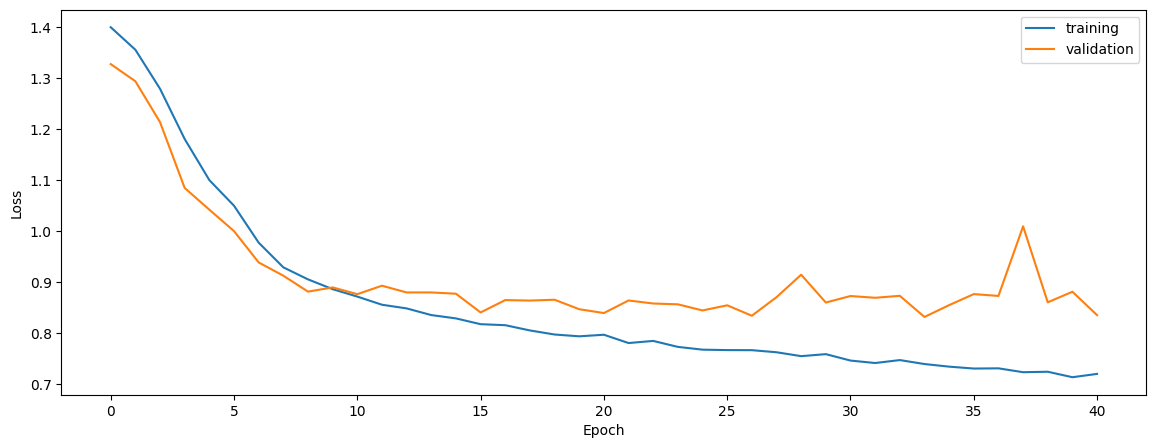

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7055796784592074
0.6772612436403432
0.659959178772962


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.7055796784592074
0.6772612436403432
0.659959178772962


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7032025259359495
0.6821946169772257
0.6540409155357505


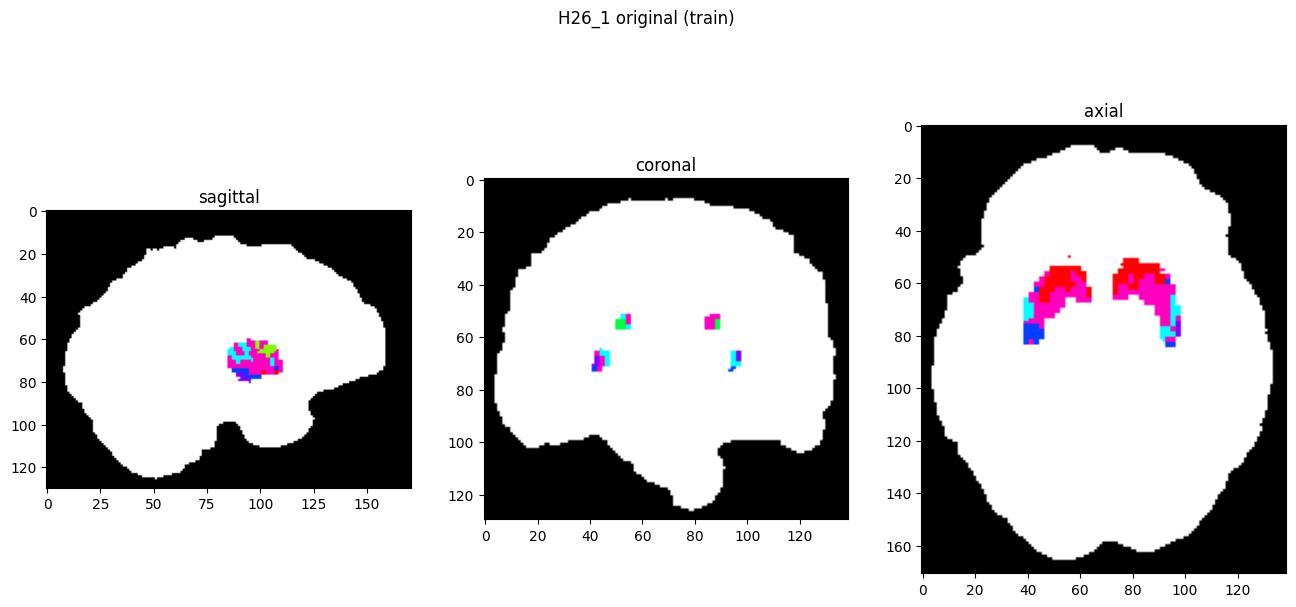

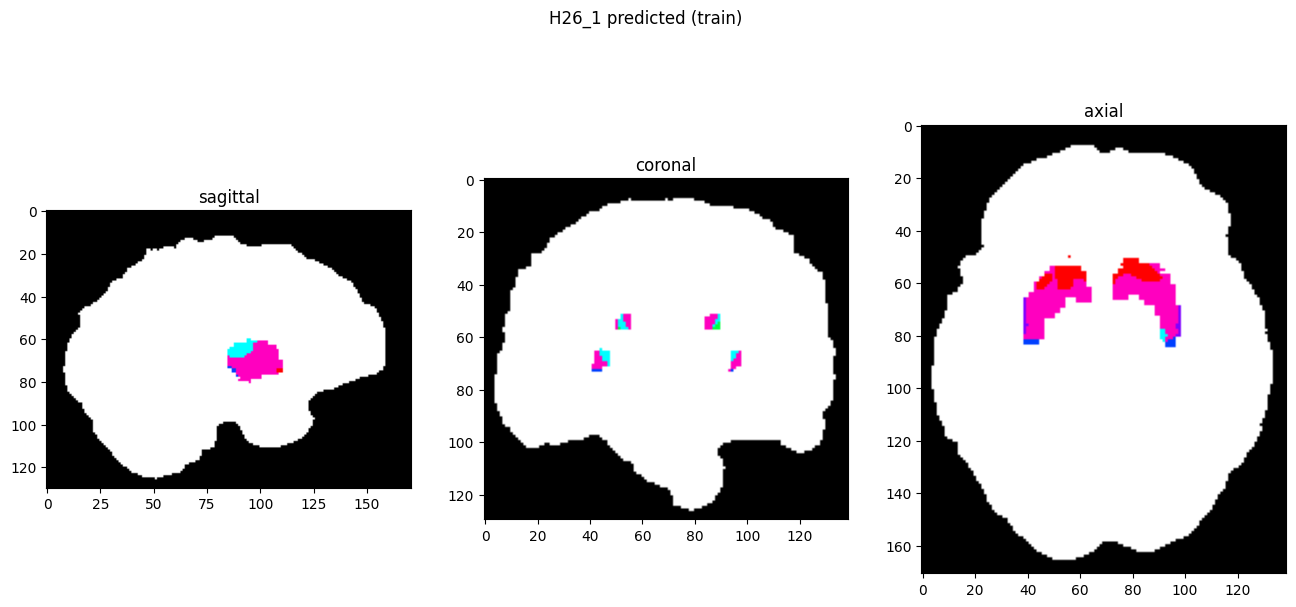

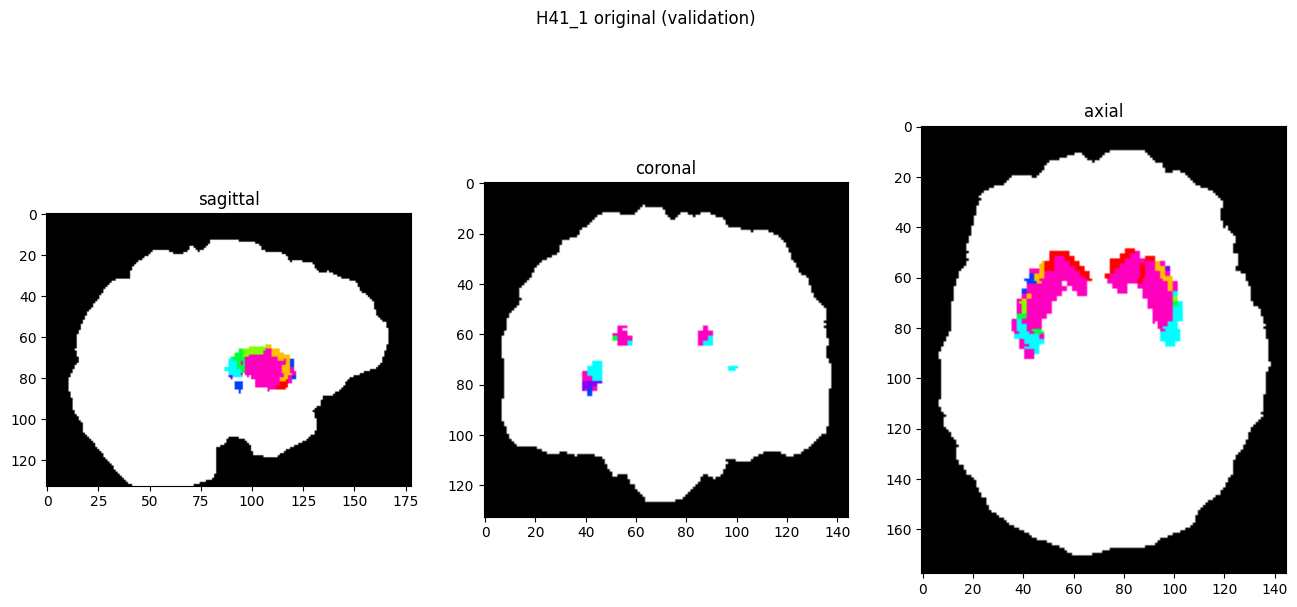

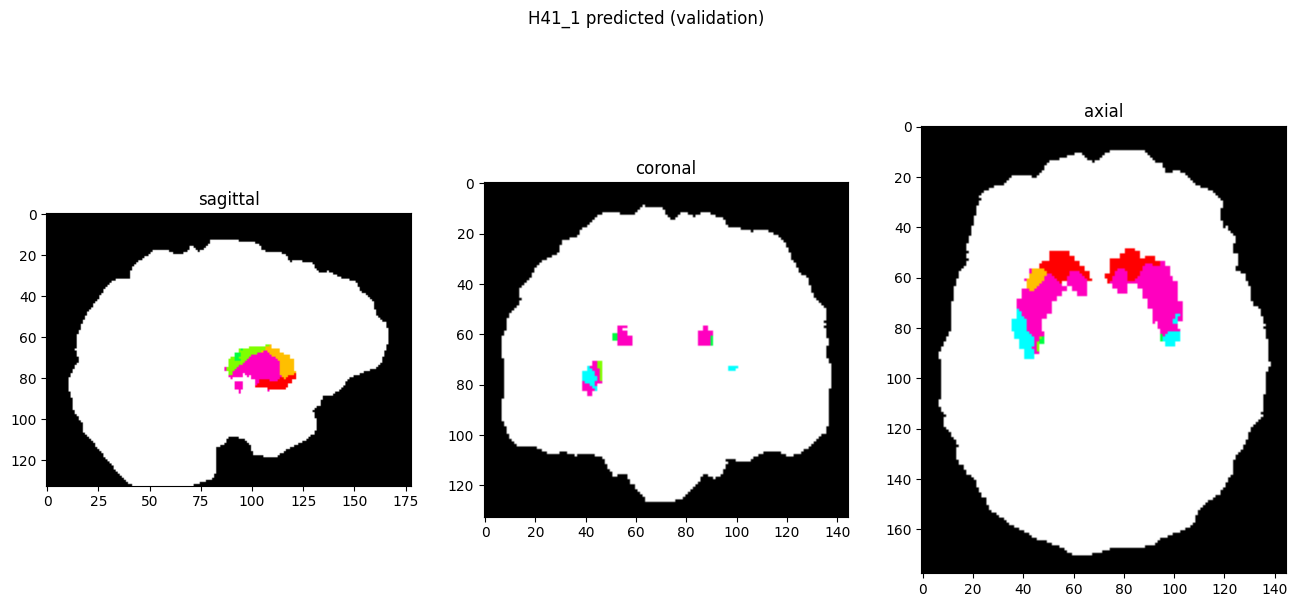

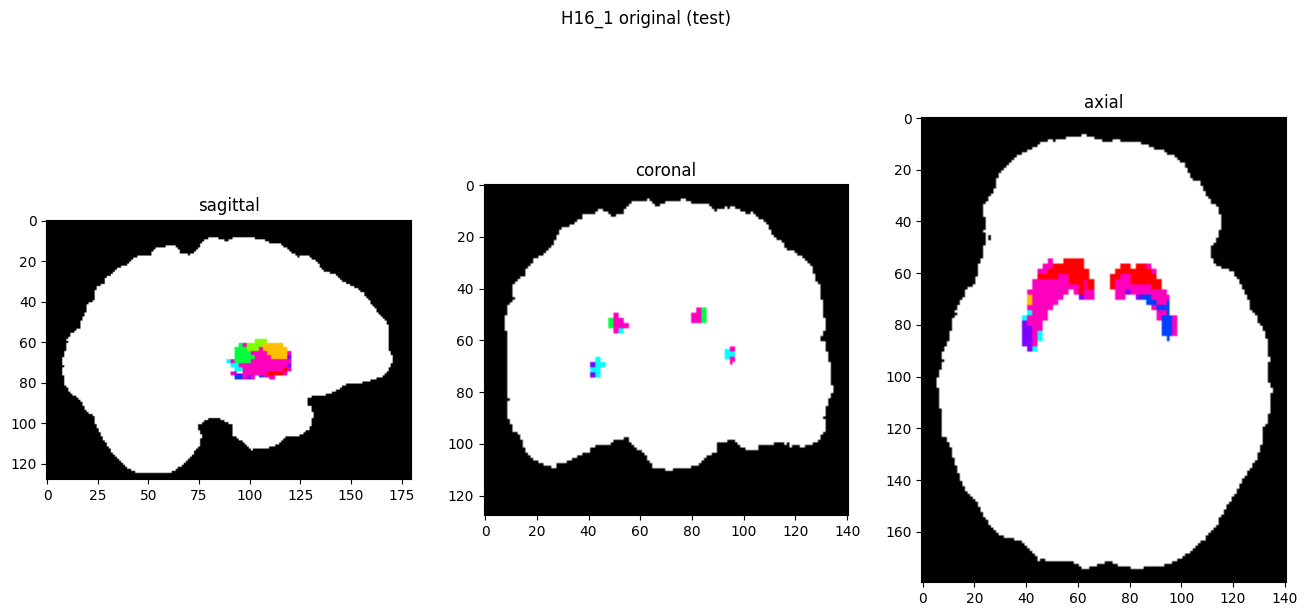

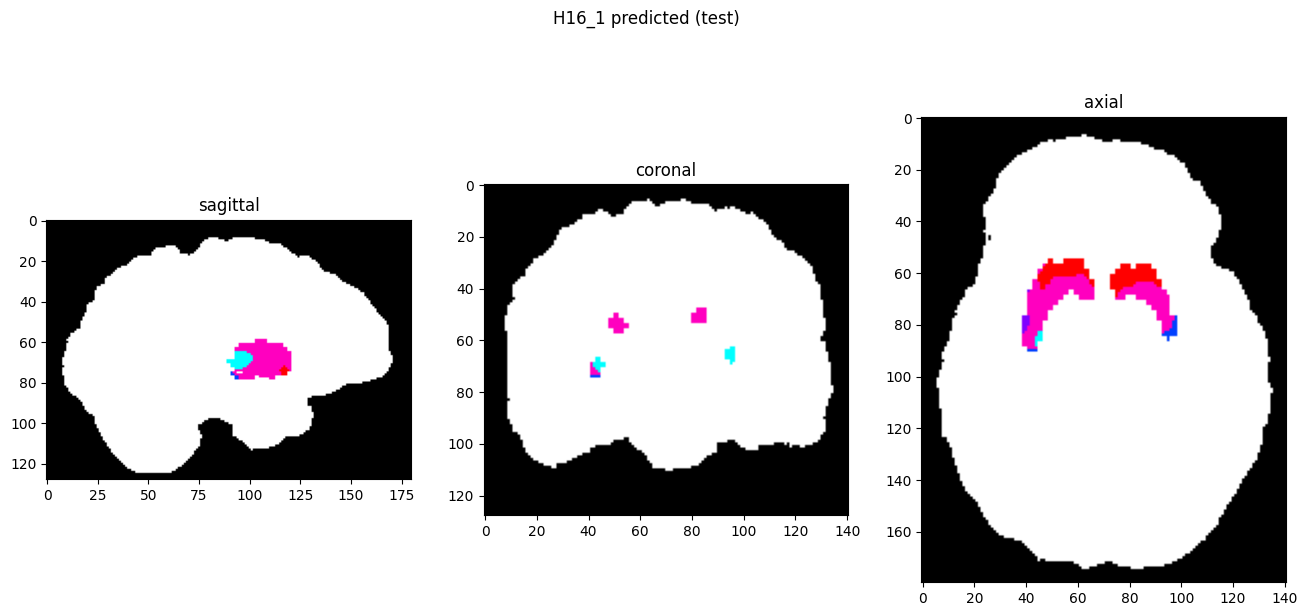

In [10]:
showResults(model, gen, threshold=0)